 Object Type         | Description                                                           
 ------------------- | --------------------------------------------------------------------- 
 `Team`              | The team associated with the event.                                   
 `From`              | The player in possession of the ball at the start of the event.       
 `To`                | The player in possession of the ball at the end of the event if the ownership changed.|
 `case:concept:name` | Unique ID for each case--an attack. 'AA' indicates away team attack, 'HA' indicates home team attack    
 `end_grid`          | The grid zone where the event ends.                              
 ------------------- | --------------------------------------------------------------------- 
 Attribute                      | Description                                               
 `attribute:subtype`            | Event subtype (e.g. `"PASS"`, `"GOAL"`, `"SHOT"`). For details please refer to the data documentation.     
 `attribute:start_x`, `start_y` | X/Y coordinates of the ball at the start of the event.        
 `attribute:end_x`, `end_y`     | X/Y coordinates of the ball at the end of the event.          
 `attribute:duration`           | Duration (in seconds) of the event.                           
 `attribute:travel_distance`    | Distance traveled by the ball.                                
 `attribute:start_grid`         | Grid ID where the event begins.                               
 `attribute:crossed_grid`       | If the event start in one grid and ends in another.           
 `attribute:attack_game`        | Identifier for attack sequence. Combined count of both team. 
 `attribute:attack_successful`  | Boolean flag — `True` if the attack led to a goal.            
 `attribute:home_team_score`    | Cumulative score of the home team at this point in the match.
 `attribute:away_team_score`    | Cumulative score of the away team at this point in the match. 


In [1]:
import pandas as pd
import pm4py
from Soccer_ocel import soccer_ocel_df, soccer_df_to_ocel
import numpy as np
from filters_and_analysis import filter_by_involved_player, filter_by_last_player, movement_frequency_report

In [3]:
# settings
## Resolution of the grid
x_fields = 4
y_fields = 3

df = pd.read_csv('sample-data\data\Sample_Game_1\Sample_Game_1_RawEventsData.csv')
tracking_data_away_df = pd.read_csv('sample-data\data\Sample_Game_1\Sample_Game_1_RawTrackingData_Away_Team.csv', skiprows=2)
tracking_data_home_df = pd.read_csv('sample-data\data\Sample_Game_1\Sample_Game_1_RawTrackingData_Home_Team.csv', skiprows=2)

ocel_df = soccer_ocel_df(df, tracking_data_home_df, tracking_data_away_df, x_fields=x_fields, y_fields=y_fields)

c:\Users\Vito\Documents\pm\Soccer\Soccer_ocel.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grid_change_events.rename(columns={'Grid Position': 'To Position',


In [ ]:
#ocel_df = ocel_df[~((ocel_df['concept:name'] == 'Player changes position') & (ocel_df['end_grid'].isna()))]

In [4]:
ocel_df['concept:name'] = ocel_df.apply(lambda row: f"{row['concept:name']}-{row['end_grid']}" if pd.notnull(row['end_grid']) and row['concept:name']=='Player changes position' else row['concept:name'],axis=1)

In [ ]:
#define classes among players--goal keeper -- attacker -- defender

In [5]:
from pm4py.objects.ocel.util.log_ocel import log_to_ocel_multiple_obj_types
def soccer_df_to_ocel(df):
    #df = pm4py.format_dataframe(df, case_id='case:concept:name', activity_key='Activity', timestamp_key='Timestamp')
    event_log = pm4py.convert_to_event_log(df)

    # convert to ocel
    ocel= log_to_ocel_multiple_obj_types(event_log, activity_column='concept:name'
                                         , timestamp_column='time:timestamp'
                                         , obj_types=['From', 'To','ball']
                                         ,additional_event_attributes=['attribute:subtype','Team','end_grid','case:concept:name'
                                                                       , 'attribute:start_x', 'attribute:start_y'
                                                                       , 'attribute:end_x', 'attribute:end_y' 
                                                                       , 'attribute:duration', 'attribute:travel_distance'
                                                                       , 'attribute:start_grid', 'attribute:crossed_grid'
                                                                       , 'attribute:attack_game', 'attribute:attack_successful'
                                                                       , 'attribute:home_team_score', 'attribute:away_team_score'
                                                                       ])
    return ocel

In [21]:
ocel= soccer_df_to_ocel(ocel_df)

In [ ]:
dfg=pm4py.ocel.discover_ocdfg(ocel)
pm4py.visualization.ocel.ocdfg.visualizer.apply(dfg)

In [ ]:
#split by team
Away_df=ocel_df[ocel_df['Team']=='Away']
Home_df=ocel_df[ocel_df['Team']=='Home']

In [6]:
#shot case only by team
All_shot_attacks=ocel_df[
    ocel_df['concept:name'].str.startswith('SHOT') |
    ocel_df['concept:name'].str.endswith('GOAL')]['case:concept:name'].unique()

Goal_attack=ocel_df[ocel_df['concept:name'].str.endswith('GOAL')]['case:concept:name'].unique()
attack_df=ocel_df[ocel_df['case:concept:name'].isin(All_shot_attacks)]
Goal_attack_df=ocel_df[ocel_df['case:concept:name'].isin(Goal_attack)]
Failed_attack_df=ocel_df[ocel_df['case:concept:name'].isin(All_shot_attacks)&~ocel_df['case:concept:name'].isin(Goal_attack)]

#shot case last player only by team
last_player_attack_df=filter_by_last_player(attack_df)
last_player_goal_attack_df=filter_by_last_player(Goal_attack_df)
last_player_failed_attack_df=filter_by_last_player(Failed_attack_df)

#shot case all involved players by team
involved_player_attack_df=filter_by_involved_player(attack_df)
involved_player_goal_attack_df=filter_by_involved_player(Goal_attack_df)
involved_player_failed_attack_df=filter_by_involved_player(Failed_attack_df)

In [58]:
aa_max = pd.Series(ocel_df['case:concept:name'].unique()).str.extract(r'^AA(\d+)$')[0].dropna().astype(int).max()
print('Away team made ',aa_max,' attacks')
ha_max = pd.Series(ocel_df['case:concept:name'].unique()).str.extract(r'^HA(\d+)$')[0].dropna().astype(int).max()
print('Home team made ',ha_max,' attacks')

Away team made  175  attacks
Home team made  180  attacks


In [7]:
#shot case only by team
All_shot_attacks=ocel_df[
    ocel_df['concept:name'].str.startswith('SHOT') |
    ocel_df['concept:name'].str.endswith('GOAL')]['case:concept:name'].unique()
Goal_attack=ocel_df[ocel_df['concept:name'].str.endswith('GOAL')]['case:concept:name'].unique()

#All_shot_attacks=ocel_df[
#    ocel_df['concept:name'].str.startswith('SHOT') |
#    ocel_df['attribute:subtype'].str.endswith('GOAL')]['case:concept:name'].unique()
#Goal_attack = ocel_df[ocel_df['attribute:subtype'].str.endswith('GOAL', na=False)]['case:concept:name'].unique()

attack_df=ocel_df[ocel_df['case:concept:name'].isin(All_shot_attacks)]
Goal_attack_df=ocel_df[ocel_df['case:concept:name'].isin(Goal_attack)]
Failed_attack_df=ocel_df[ocel_df['case:concept:name'].isin(All_shot_attacks)&~ocel_df['case:concept:name'].isin(Goal_attack)]

In [8]:
Goal_attack_ocel= soccer_df_to_ocel(Goal_attack_df)
Failed_attack_ocel= soccer_df_to_ocel(Failed_attack_df)
Failed_attack_ocel_home= soccer_df_to_ocel(Failed_attack_df[Failed_attack_df['Team']=='Home'])
Failed_attack_ocel_away= soccer_df_to_ocel(Failed_attack_df[Failed_attack_df['Team']=='Away'])

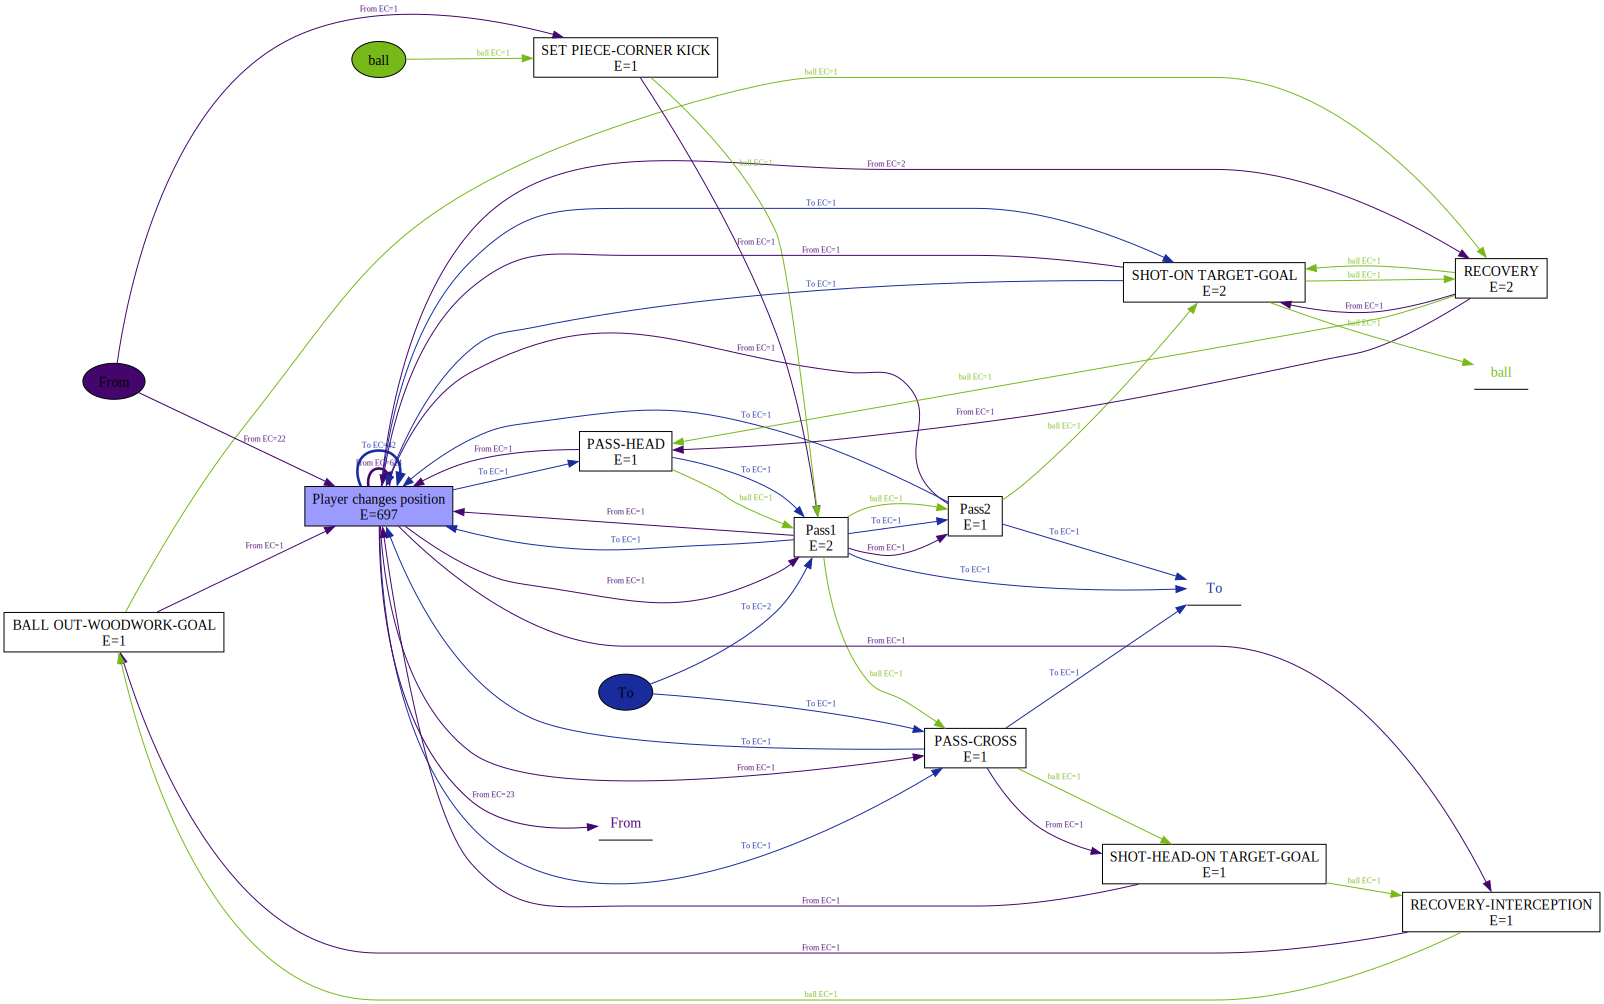

In [ ]:
dfg=pm4py.ocel.discover_ocdfg(Goal_attack_ocel)
pm4py.visualization.ocel.ocdfg.visualizer.apply(dfg)

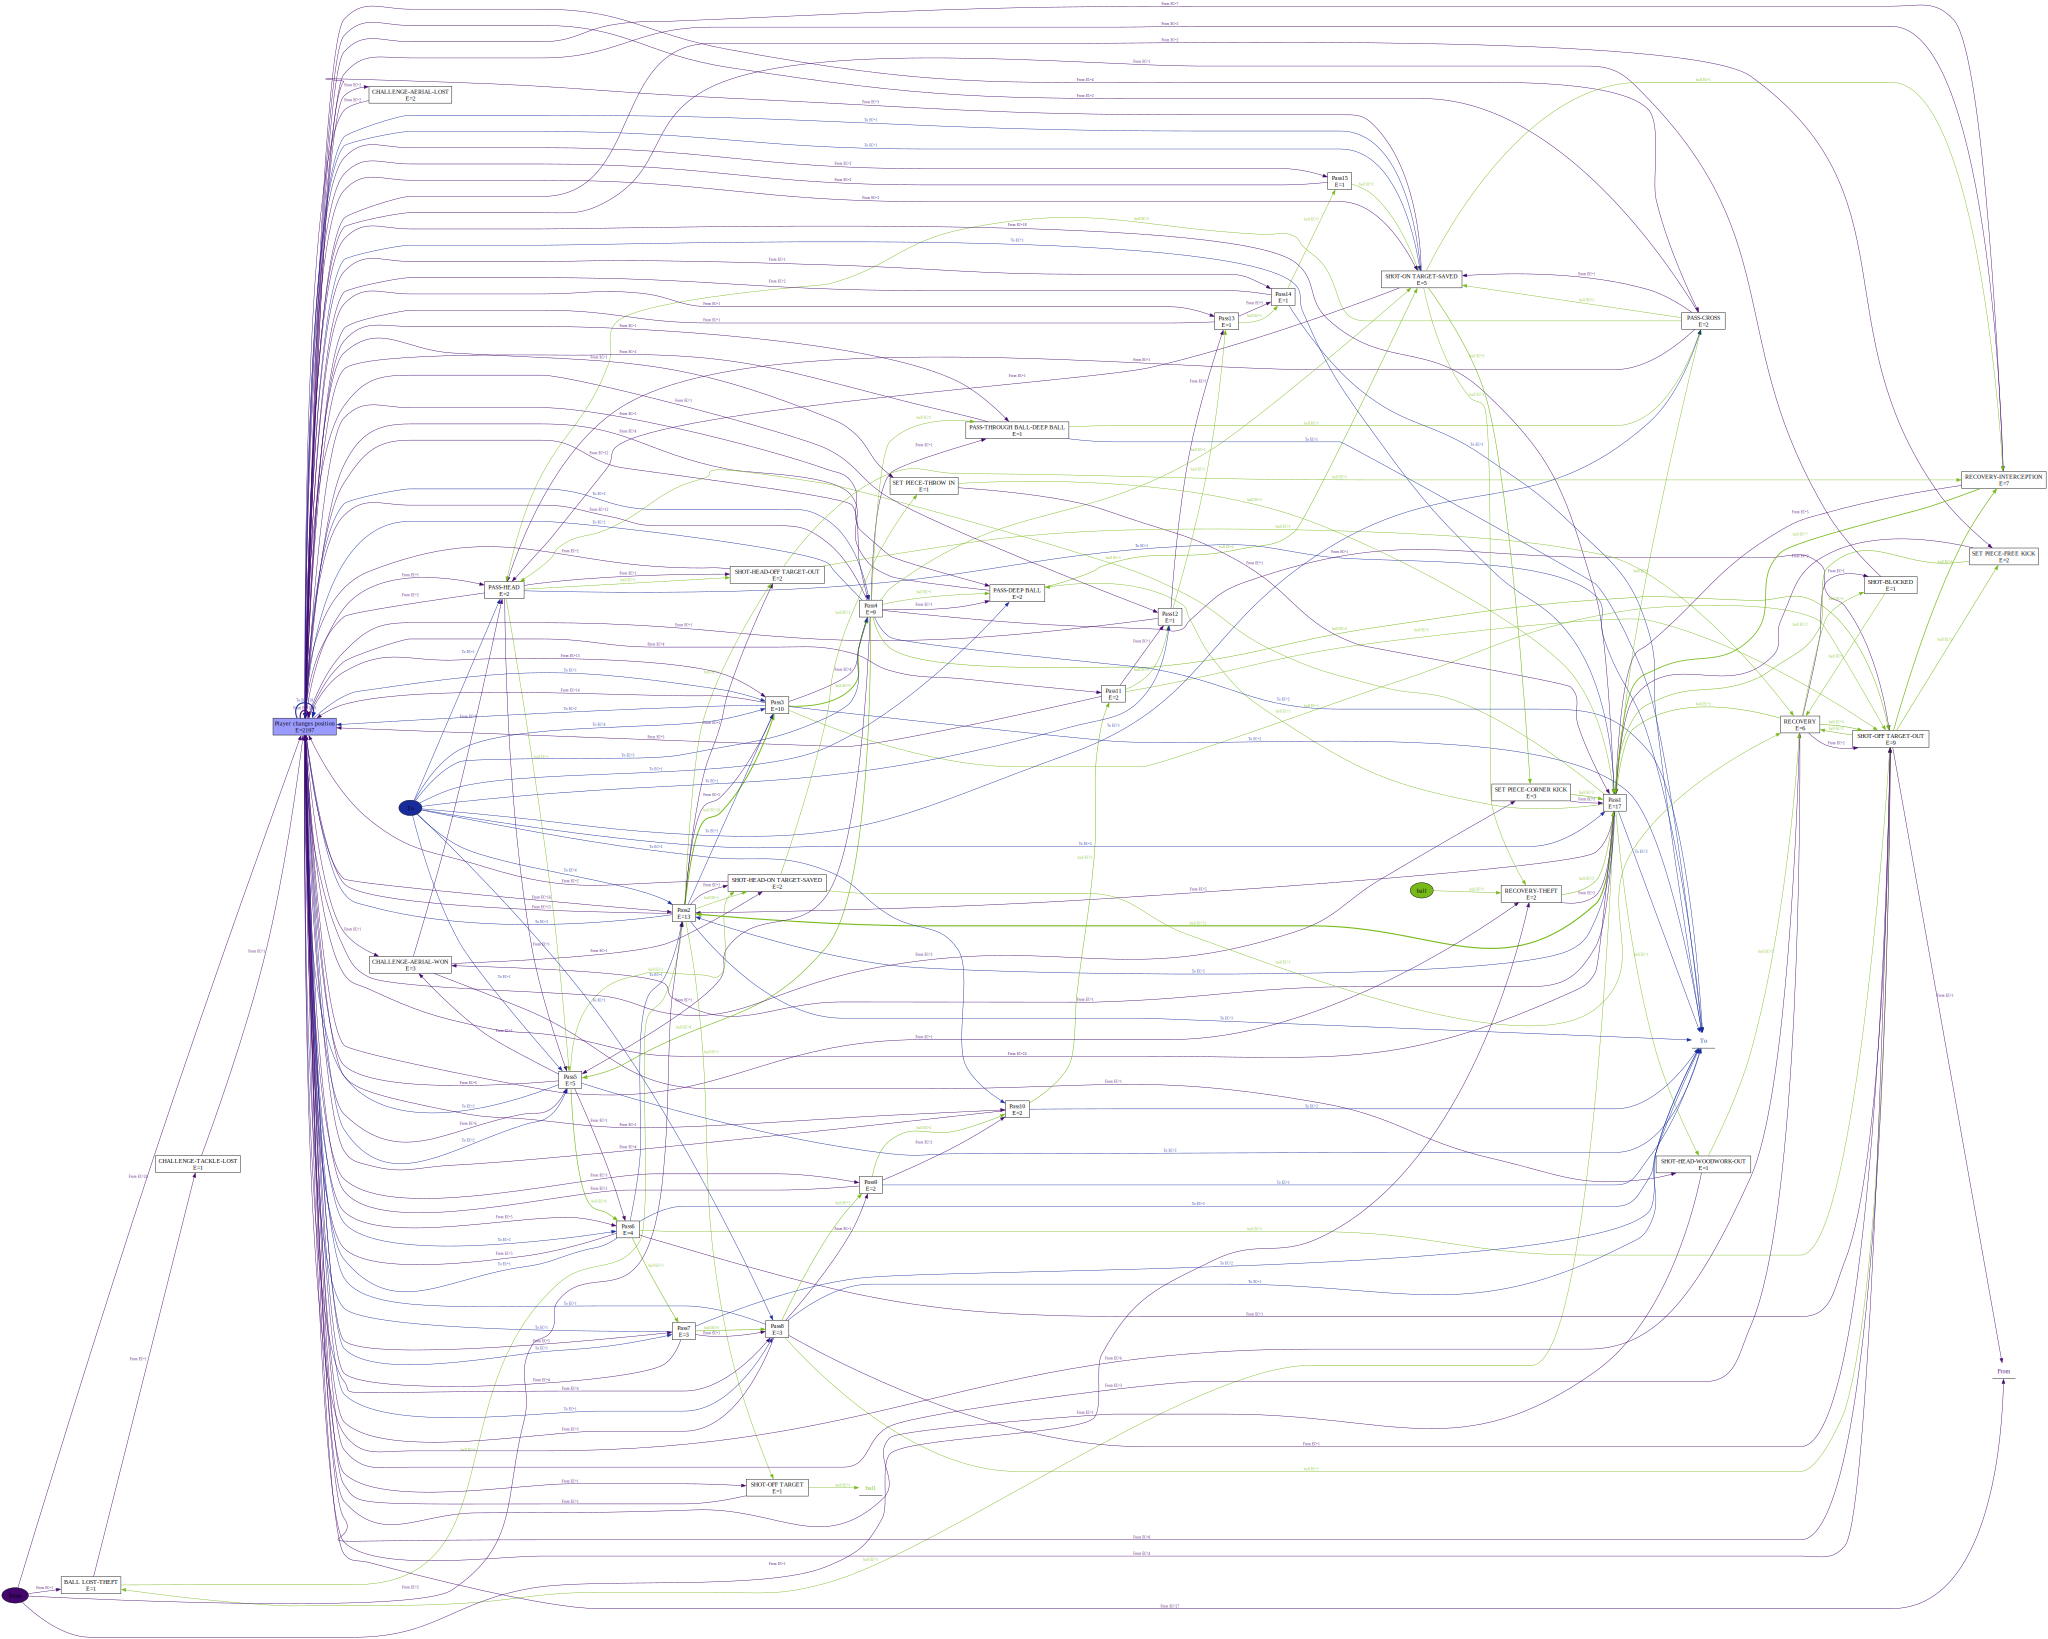

In [ ]:
dfg=pm4py.ocel.discover_ocdfg(Failed_attack_ocel)
pm4py.visualization.ocel.ocdfg.visualizer.apply(dfg)

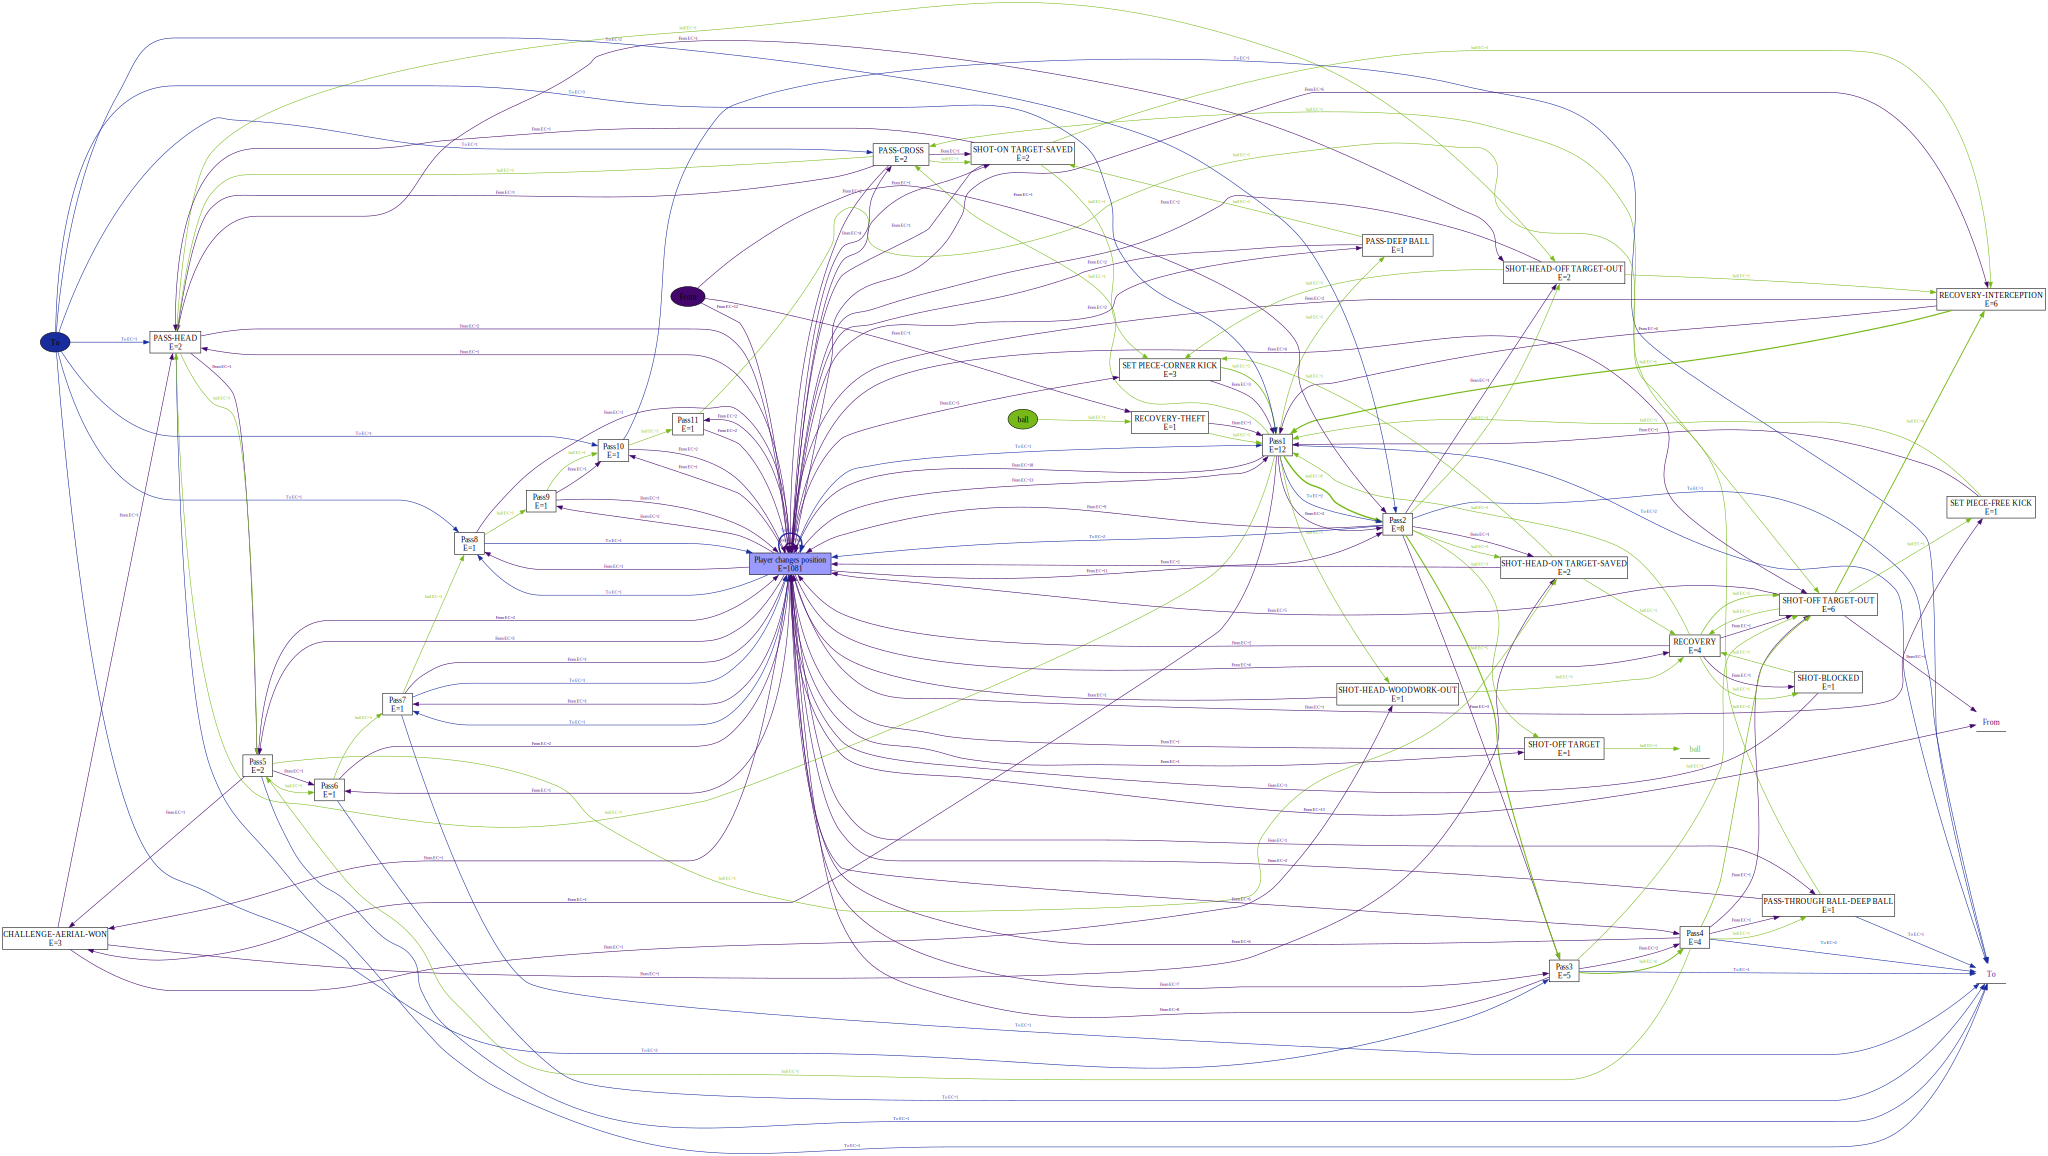

In [ ]:
dfg=pm4py.ocel.discover_ocdfg(Failed_attack_ocel_home)
pm4py.visualization.ocel.ocdfg.visualizer.apply(dfg)

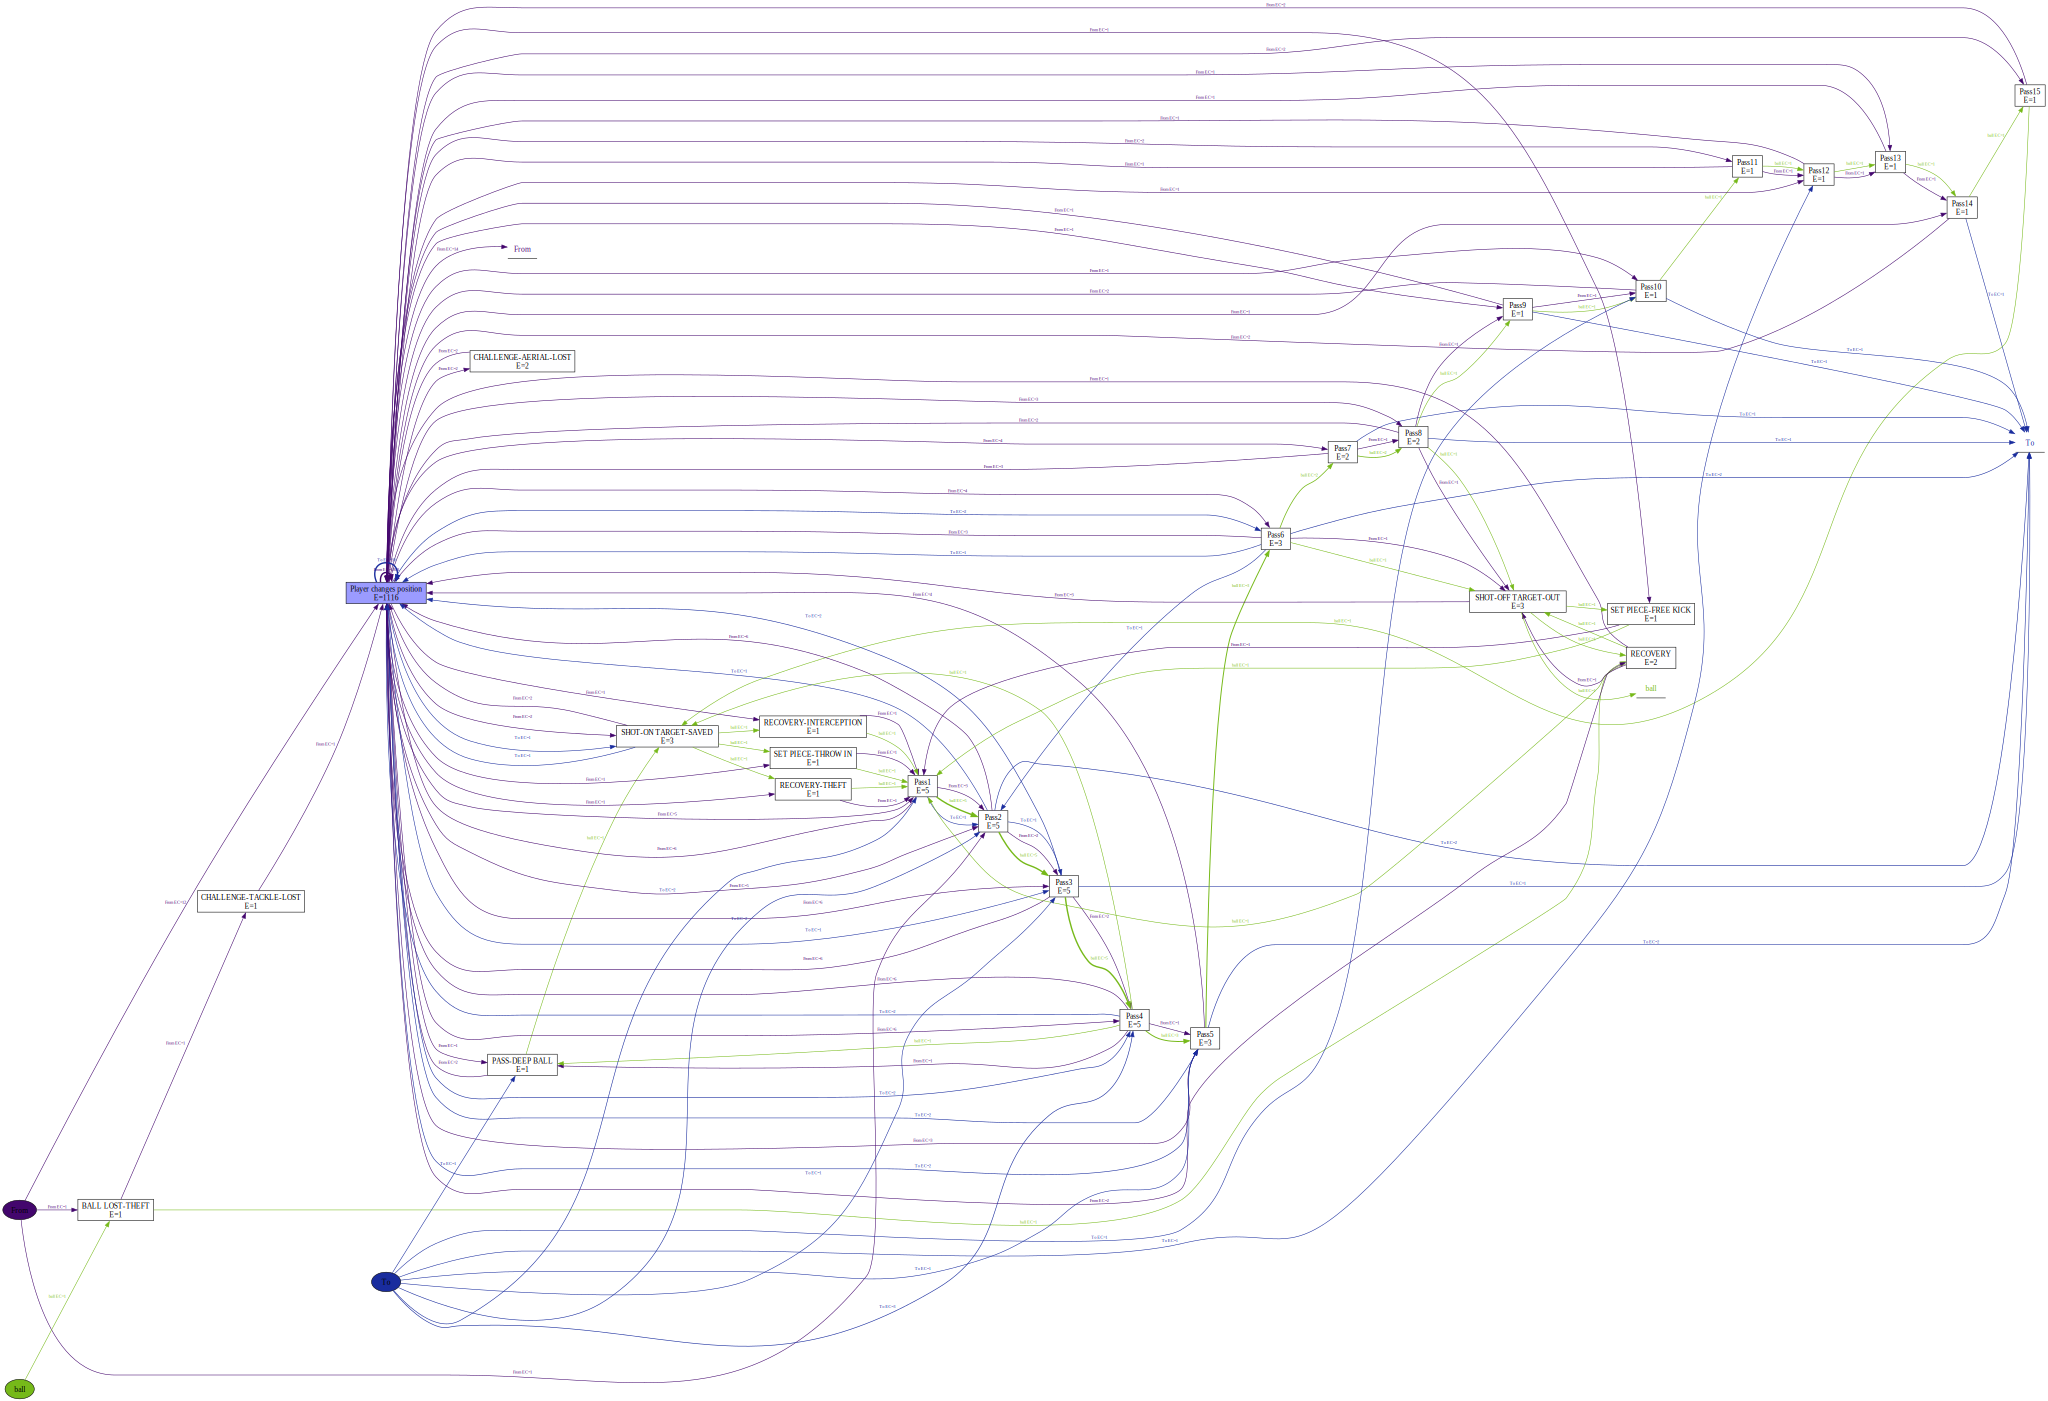

In [ ]:
dfg=pm4py.ocel.discover_ocdfg(Failed_attack_ocel_away)
pm4py.visualization.ocel.ocdfg.visualizer.apply(dfg)

In [9]:
#shot case last player only by team
#last_player_attack_df=filter_by_last_player(attack_df)
#last_player_goal_attack_df=filter_by_last_player(Goal_attack_df)
#last_player_failed_attack_df=filter_by_last_player(Failed_attack_df)

#shot case all involved players by team
involved_player_attack_df=filter_by_involved_player(attack_df)
involved_player_goal_attack_df=filter_by_involved_player(Goal_attack_df)
involved_player_failed_attack_df=filter_by_involved_player(Failed_attack_df)

In [10]:
involved_player_Goal_attack_ocel= soccer_df_to_ocel(involved_player_goal_attack_df)
involved_player_Failed_attack_ocel= soccer_df_to_ocel(involved_player_failed_attack_df)
involved_player_Failed_attack_ocel_home= soccer_df_to_ocel(involved_player_failed_attack_df[involved_player_failed_attack_df['Team']=='Home'])
involved_player_Failed_attack_ocel_away= soccer_df_to_ocel(involved_player_failed_attack_df[involved_player_failed_attack_df['Team']=='Away'])

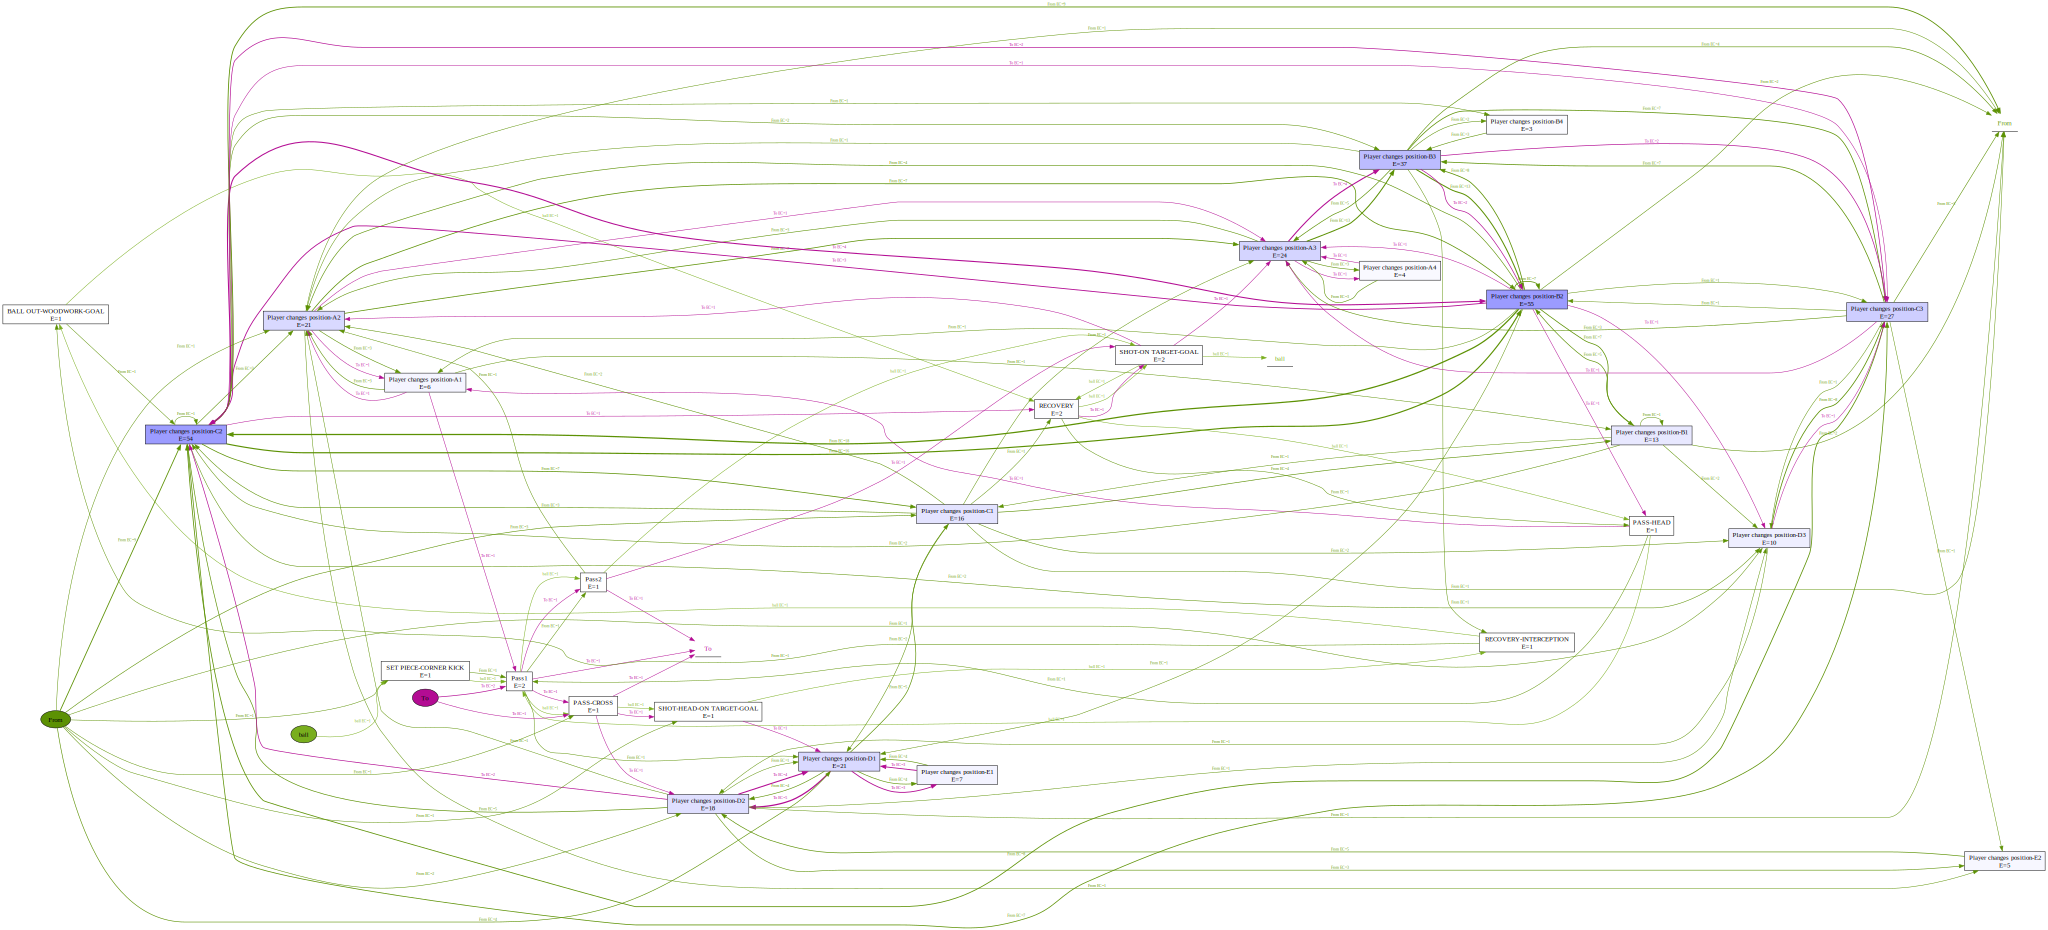

In [11]:
dfg=pm4py.ocel.discover_ocdfg(involved_player_Goal_attack_ocel)
pm4py.visualization.ocel.ocdfg.visualizer.apply(dfg)

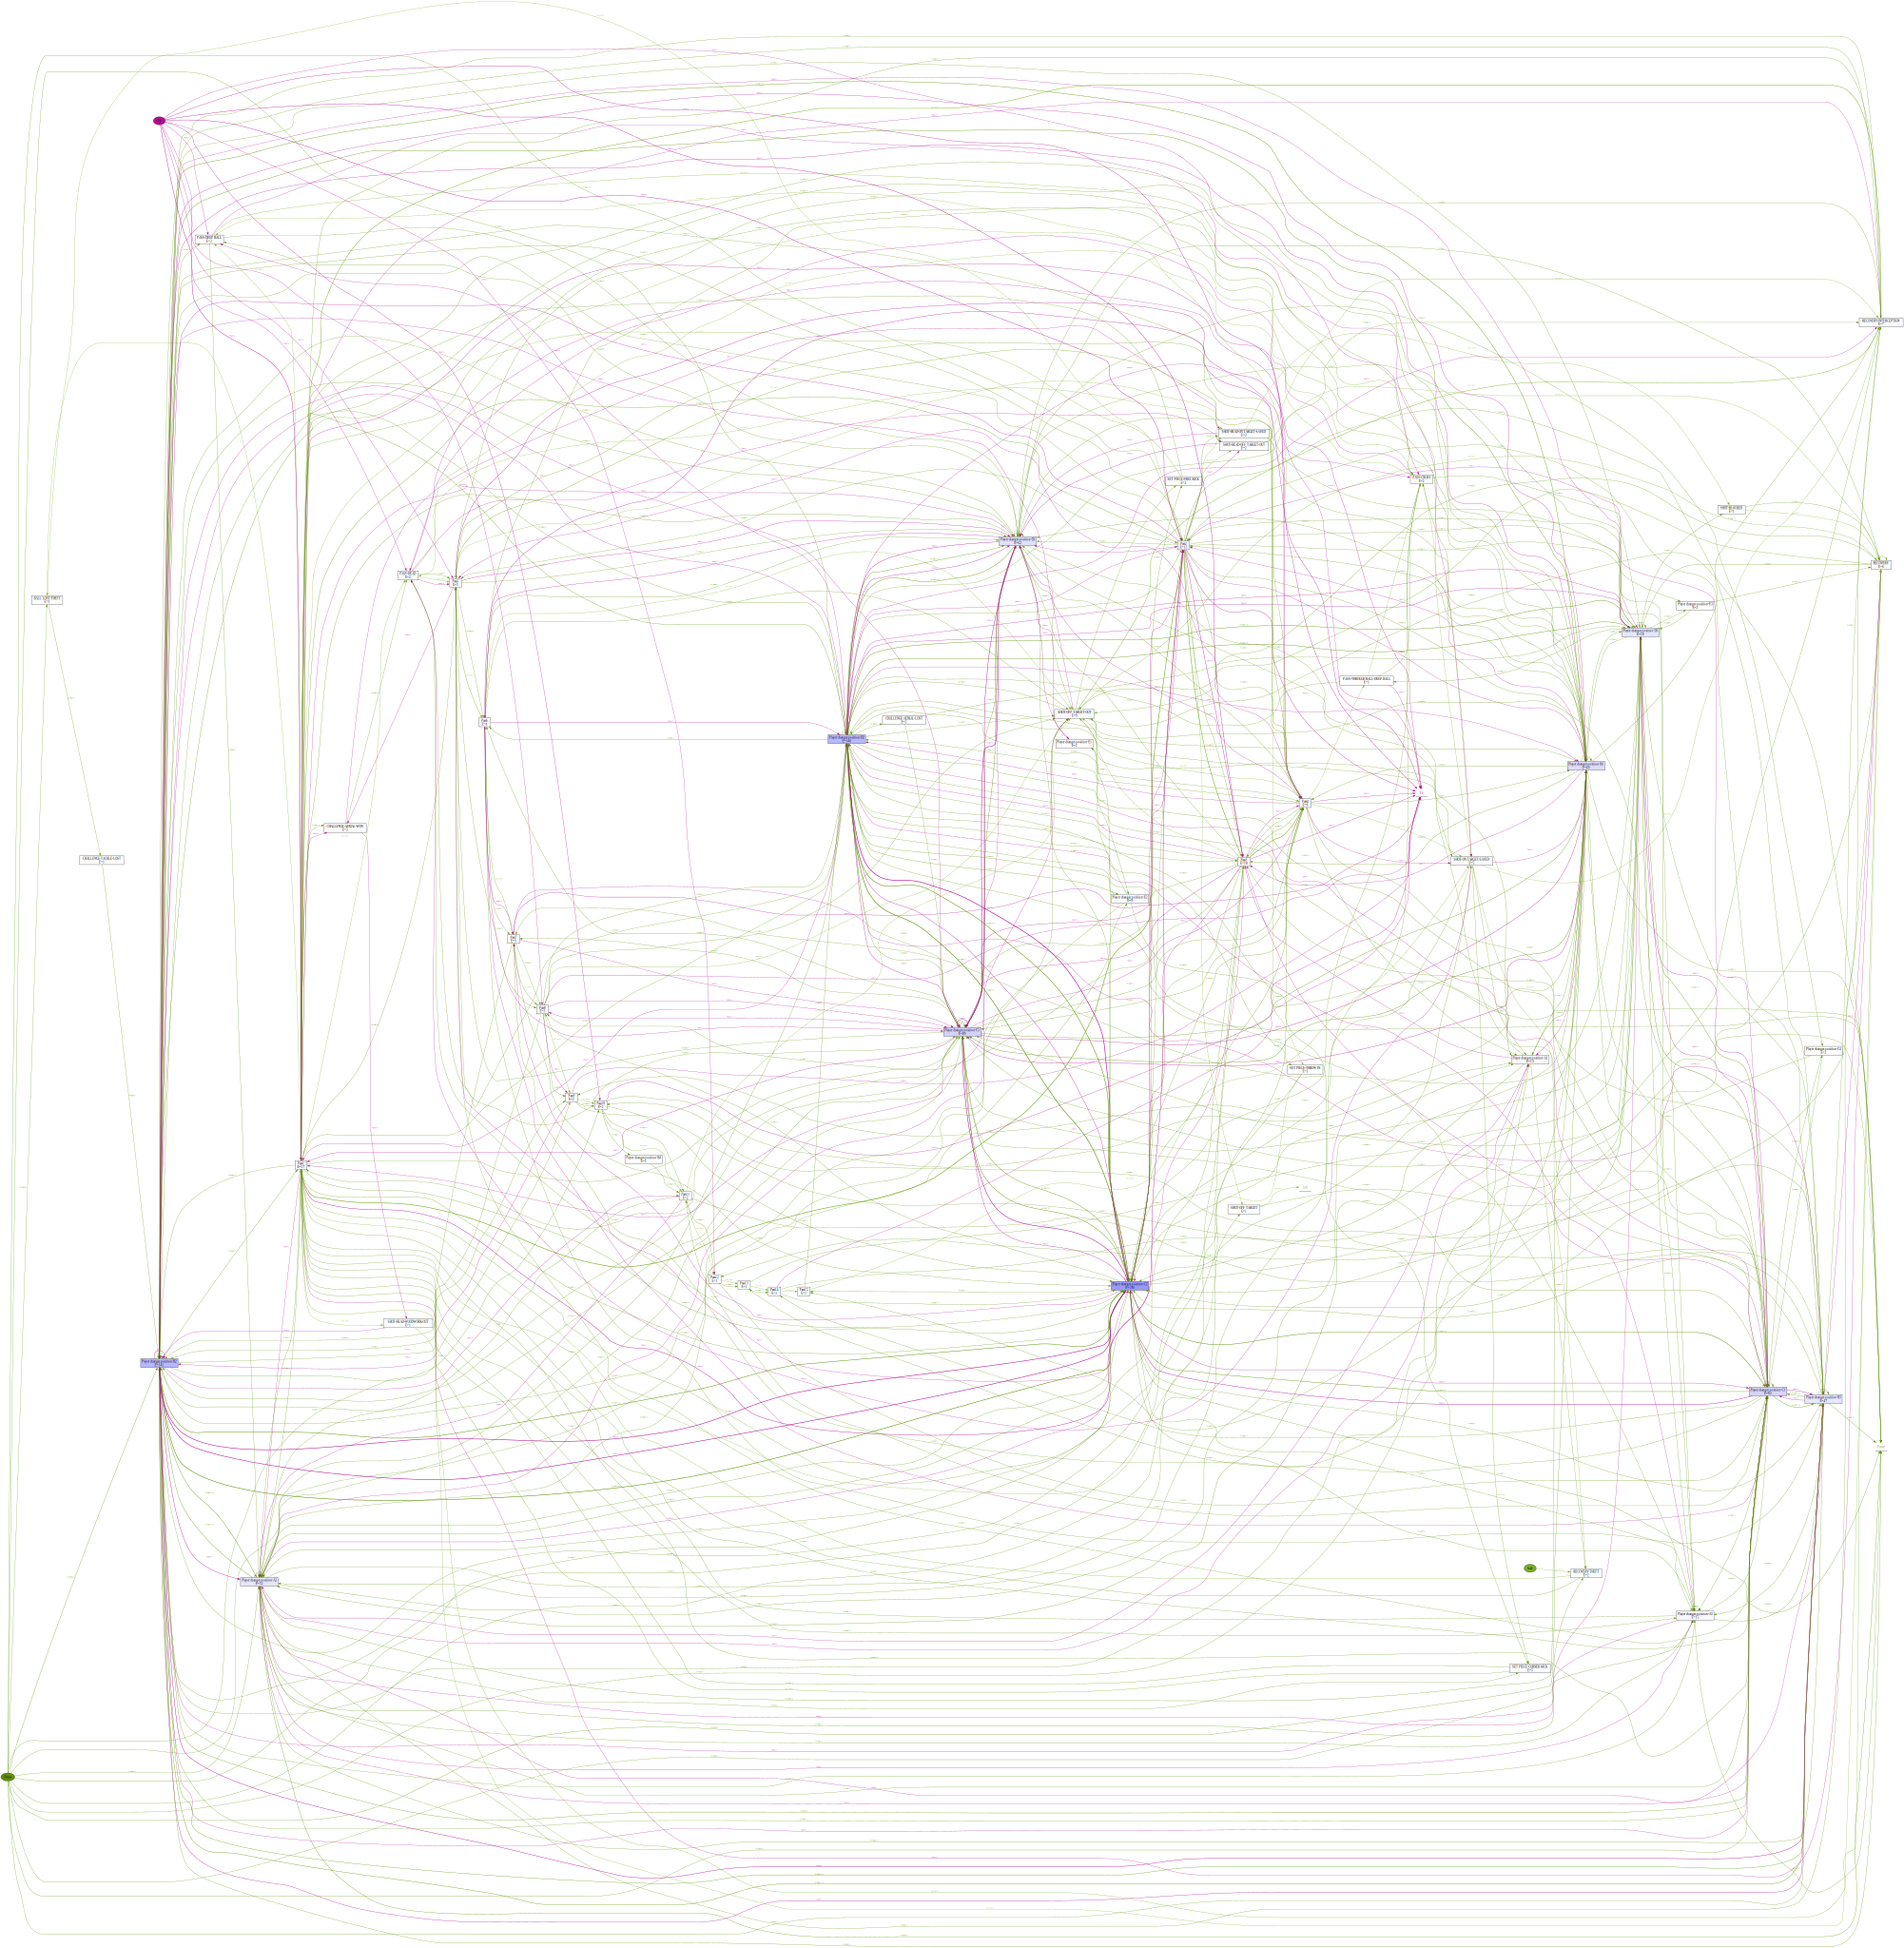

In [12]:
dfg=pm4py.ocel.discover_ocdfg(involved_player_Failed_attack_ocel)
pm4py.visualization.ocel.ocdfg.visualizer.apply(dfg)

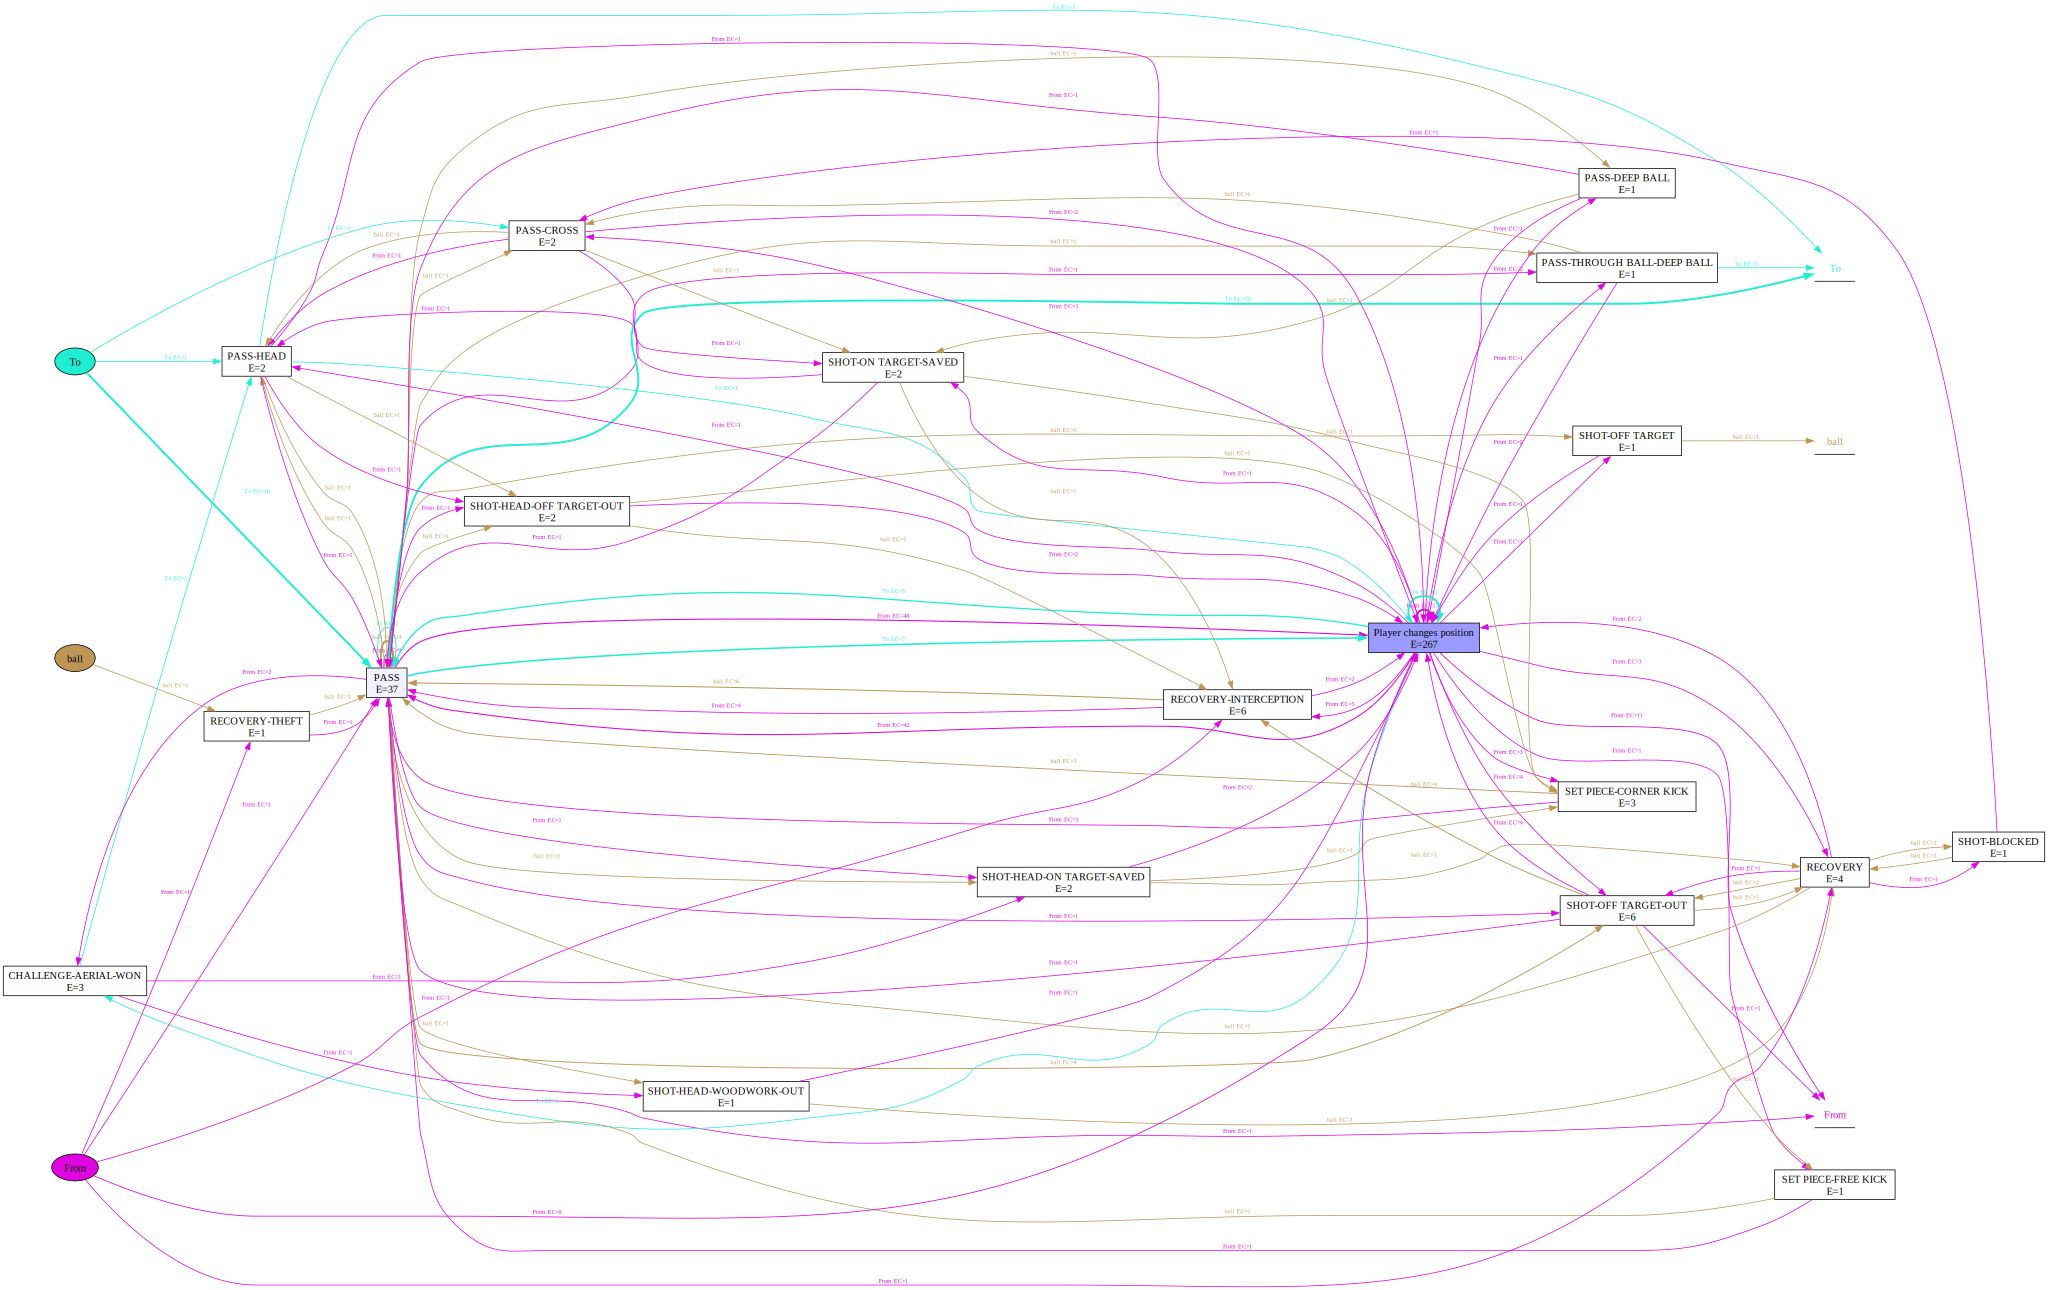

In [ ]:
dfg=pm4py.ocel.discover_ocdfg(involved_player_Failed_attack_ocel_home)
pm4py.visualization.ocel.ocdfg.visualizer.apply(dfg)

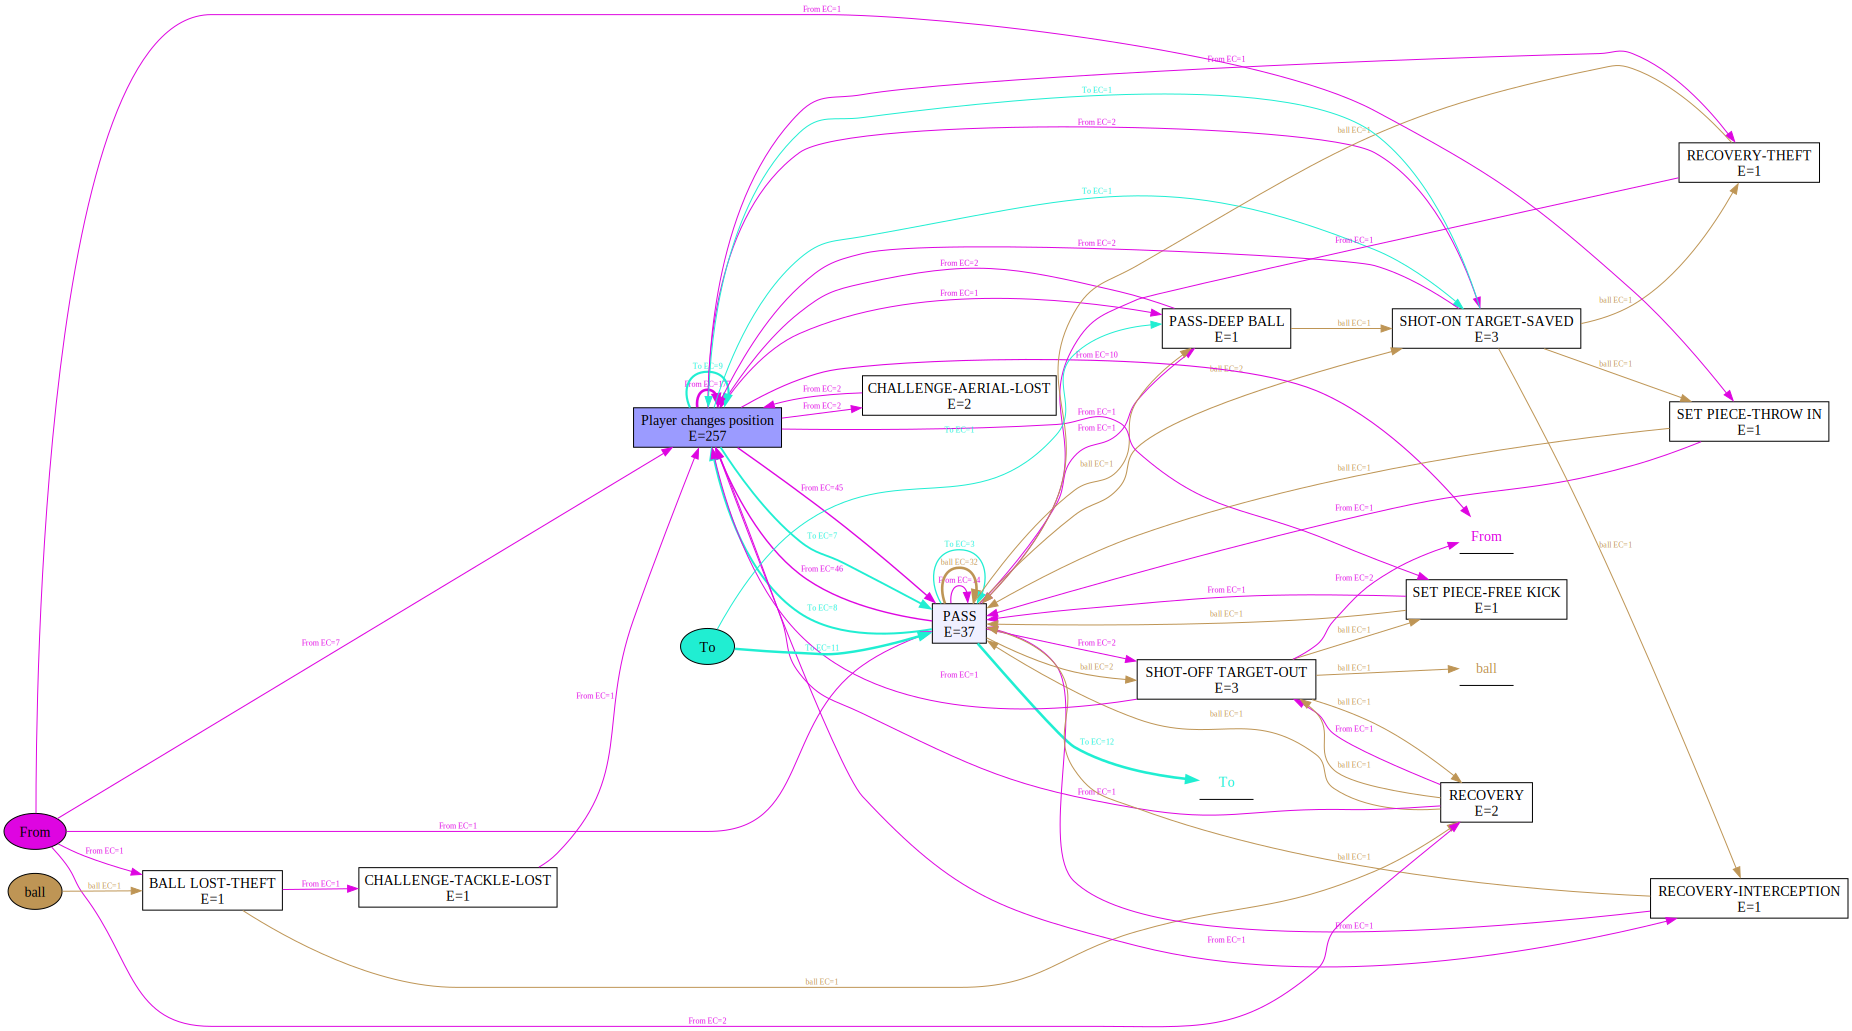

In [ ]:
dfg=pm4py.ocel.discover_ocdfg(involved_player_Failed_attack_ocel_away)
pm4py.visualization.ocel.ocdfg.visualizer.apply(dfg)

In [69]:
print('For successful shots')
result= movement_frequency_report(last_player_goal_attack_df,involved_player_goal_attack_df)

For successful shots
  case:concept:name  team last_player  position_changes  \
0             HA118  Home     Player5                 7   
1             HA121  Home    Player10                14   
2             HA133  Home     Player9                 6   
3               HA4  Home     Player9                13   

   total_position_changes  average_per_player  num_involved_players  
0                       7            7.000000                     1  
1                      27           13.500000                     2  
2                       6            6.000000                     1  
3                      40           13.333333                     3  
In this game, a total of 4 shots were made. 
The aggregated total shooter grid travel is 40 
The average shooter grid travel per shot is 10.0 
The aggregated total grid travel of all involved players is 80 
The average grid travel of all attacks involved players per shot is 20.0 
The average grid travel of all attacks involved play

In [68]:
print('For failed shots')
result= movement_frequency_report(last_player_failed_attack_df,involved_player_failed_attack_df)

For failed shots
   case:concept:name  team last_player  position_changes  \
0              AA103  Away    Player19                16   
1              AA138  Away    Player27                 5   
2              AA156  Away    Player23                 6   
3               AA16  Away    Player21                 7   
4              AA166  Away    Player28                 8   
5               AA36  Away    Player24                 7   
6              HA106  Home    Player12                 6   
7               HA11  Away    Player18                 0   
8               HA11  Home    Player10                 9   
9              HA132  Home     Player5                 0   
10             HA156  Home    Player10                 5   
11             HA160  Home    Player14                 7   
12             HA173  Home     Player9                 9   
13              HA19  Home     Player8                 7   
14              HA32  Away    Player17                 0   
15              HA32  H

In [16]:
player, movement=np.unique(ocel_df[ocel_df['concept:name']=='Player changes position']['From'], return_counts=True)
player=player[np.argsort(movement)]
movement=np.sort(movement)
print(player[0],'and',player[1],'made the least amount of travel through out the game and they are likely the goalkeeper.')
print(player[0],'belongs to the',ocel_df[ocel_df['From']==player[0]].iloc[0]['Team'],'team')
print(player[1],'belongs to the',ocel_df[ocel_df['From']==player[1]].iloc[0]['Team'],'team')

Player11 and Player25 made the least amount of travel through out the game and they are likely the goalkeeper.
Player11 belongs to the Home team
Player25 belongs to the Away team


In [ ]:
from filters_and_analysis import get_player_trajectory, fraction_time_in_goal_area

for col in tracking_data_away_df.columns:
    if col.startswith("Player"):
        _,x_trace,y_trace=get_player_trajectory(tracking_data_away_df,col)
        print(col)
        fraction_time_in_goal_area(x_trace,y_trace, 'Away')
for col in tracking_data_home_df.columns:
    if col.startswith("Player"):
        _,x_trace,y_trace=get_player_trajectory(tracking_data_home_df,col)
        print(col)
        fraction_time_in_goal_area(x_trace,y_trace, 'Home')


Player25
0.16325531357323145
Player15
0.033495165717280666
Player16
0.012764989034936485
Player17
0.014971794270581908
Player18
0.0022068052356454216
Player19
0.0033102078534681324
Player20
0.03579162241562418
Player21
0.016178640883825497
Player22
0.006089403197109085
Player23
0.006944540225921686
Player24
0.014744217480655972
Player26
0.002999875867205495
Player27
0.0006689378370550184
Player28
0.0


In [3]:
pd.set_option('display.max_columns', None)
ocel.get_extended_table()

ocel:eid            ocel:activity          ocel:timestamp  \
0             0                SET PIECE 1970-01-01 00:00:00.040   
1             1  Player changes position 1970-01-01 00:00:00.040   
2             2  Player changes position 1970-01-01 00:00:00.040   
3             3  Player changes position 1970-01-01 00:00:00.040   
4             4  Player changes position 1970-01-01 00:00:00.040   
...         ...                      ...                     ...   
904118   904118  Player changes position 1970-01-01 01:36:40.240   
904119   904119  Player changes position 1970-01-01 01:36:40.240   
904120   904120  Player changes position 1970-01-01 01:36:40.240   
904121   904121  Player changes position 1970-01-01 01:36:40.240   
904122   904122  Player changes position 1970-01-01 01:36:40.240   

       attribute:subtype  attribute:duration attribute:start_grid  \
0               KICK OFF               -0.04               [None]   
1                    NaN                 NaN                  NaN   
2                    NaN                 NaN                  NaN   
3                    NaN                 NaN                  NaN   
4                    NaN                 NaN                  NaN   
...                  ...                 ...                  ...   
904118               NaN                 NaN                  NaN   
904119               NaN                 NaN                  NaN   
904120               NaN                 NaN                  NaN   
904121               NaN                 NaN                  NaN   
904122               NaN                 NaN                  NaN   

       attribute:crossed_grid  attribute:attack_game  \
0                       False                      1   
1                         NaN                      1   
2                         NaN                      1   
3                         NaN                      1   
4                         NaN                      1   
...                       ...                    ...   
904118                    NaN                    355   
904119                    NaN                    355   
904120                    NaN                    355   
904121                    NaN                    355   
904122                    NaN                    355   

        attribute:attack_successful  attribute:home_team_score  \
0                             False                          0   
1                             False                          0   
2                             False                          0   
3                             False                          0   
4                             False                          0   
...                             ...                        ...   
904118                        False                          4   
904119                        False                          4   
904120                        False                          4   
904121                        False                          4   
904122                        False                          4   

        attribute:away_team_score  attribute:end_x  attribute:end_y  \
0                               0              NaN              NaN   
1                               0          0.41094          0.72589   
2                               0          0.52697          0.37980   
3                               0          0.41698          0.47843   
4                               0          0.40783          0.61525   
...                           ...              ...              ...   
904118                          0              NaN              NaN   
904119                          0              NaN              NaN   
904120                          0              NaN              NaN   
904121                          0              NaN              NaN   
904122                          0              NaN              NaN   

        attribute:start_x  attribute:start

In [12]:
ocel_filter=pm4py.filtering.filter_ocel_events(ocel,['Player changes position'],False)
ocel_filter.get_extended_table()

ocel:eid            ocel:activity          ocel:timestamp  \
0             0                SET PIECE 1970-01-01 00:00:00.040   
1             1  Player changes position 1970-01-01 00:00:00.040   
2             2  Player changes position 1970-01-01 00:00:00.040   
3             3  Player changes position 1970-01-01 00:00:00.040   
4             4  Player changes position 1970-01-01 00:00:00.040   
...         ...                      ...                     ...   
904118   904118  Player changes position 1970-01-01 01:36:40.240   
904119   904119  Player changes position 1970-01-01 01:36:40.240   
904120   904120  Player changes position 1970-01-01 01:36:40.240   
904121   904121  Player changes position 1970-01-01 01:36:40.240   
904122   904122  Player changes position 1970-01-01 01:36:40.240   

       attribute:subtype  attribute:duration attribute:start_grid  \
0               KICK OFF               -0.04               [None]   
1                    NaN                 NaN                  NaN   
2                    NaN                 NaN                  NaN   
3                    NaN                 NaN                  NaN   
4                    NaN                 NaN                  NaN   
...                  ...                 ...                  ...   
904118               NaN                 NaN                  NaN   
904119               NaN                 NaN                  NaN   
904120               NaN                 NaN                  NaN   
904121               NaN                 NaN                  NaN   
904122               NaN                 NaN                  NaN   

       attribute:crossed_grid  attribute:attack_game  \
0                       False                      1   
1                         NaN                      1   
2                         NaN                      1   
3                         NaN                      1   
4                         NaN                      1   
...                       ...                    ...   
904118                    NaN                    355   
904119                    NaN                    355   
904120                    NaN                    355   
904121                    NaN                    355   
904122                    NaN                    355   

        attribute:attack_successful  attribute:home_team_score  ...  \
0                             False                          0  ...   
1                             False                          0  ...   
2                             False                          0  ...   
3                             False                          0  ...   
4                             False                          0  ...   
...                             ...                        ...  ...   
904118                        False                          4  ...   
904119                        False                          4  ...   
904120                        False                          4  ...   
904121                        False                          4  ...   
904122                        False                          4  ...   

        attribute:end_x  attribute:end_y  attribute:start_x  \
0                   NaN              NaN                NaN   
1               0.41094          0.72589                NaN   
2               0.52697          0.37980                NaN   
3               0.41698          0.47843                NaN   
4               0.40783          0.61525                NaN   
...                 ...              ...                ...   
904118              NaN              NaN                NaN   
904119              NaN              NaN                NaN   
904120              NaN              NaN                NaN   
904121              NaN              NaN                NaN   
904122              NaN              NaN                NaN   

        attribute:start_y  attribute:travel_distance  ocel:type:Team  \
0     

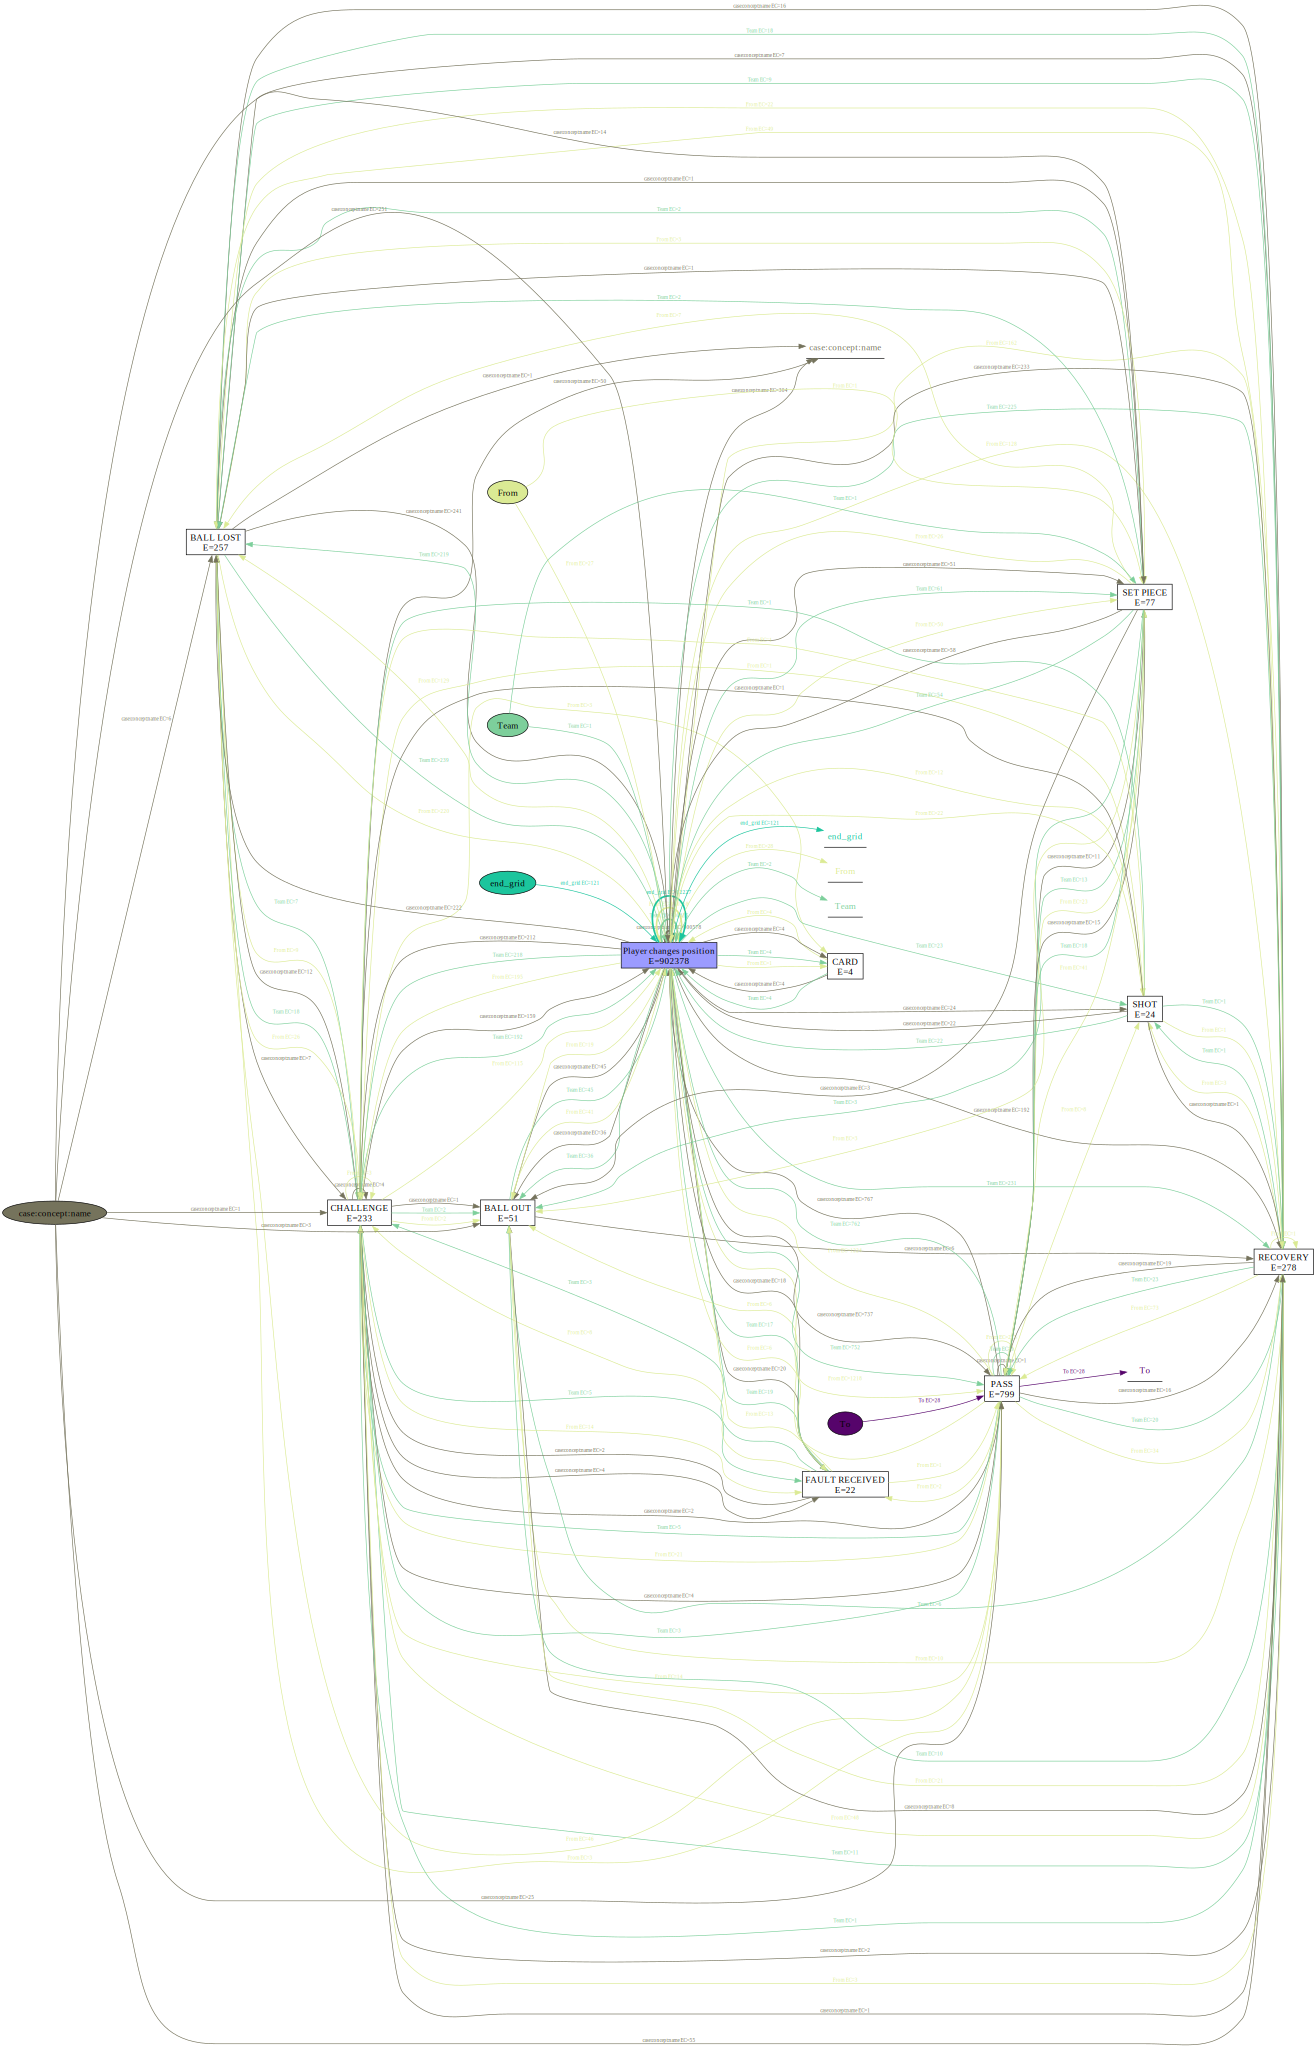

In [6]:
dfg=pm4py.ocel.discover_ocdfg(pm4py.filtering.filter_ocel_events(ocel,['Player changes position'],False))
pm4py.visualization.ocel.ocdfg.visualizer.apply(dfg)

In [ ]:
ocpn=pm4py.discovery.discover_oc_petri_net(ocel)
pm4py.visualization.ocel.ocpn.visualizer.apply(ocpn)

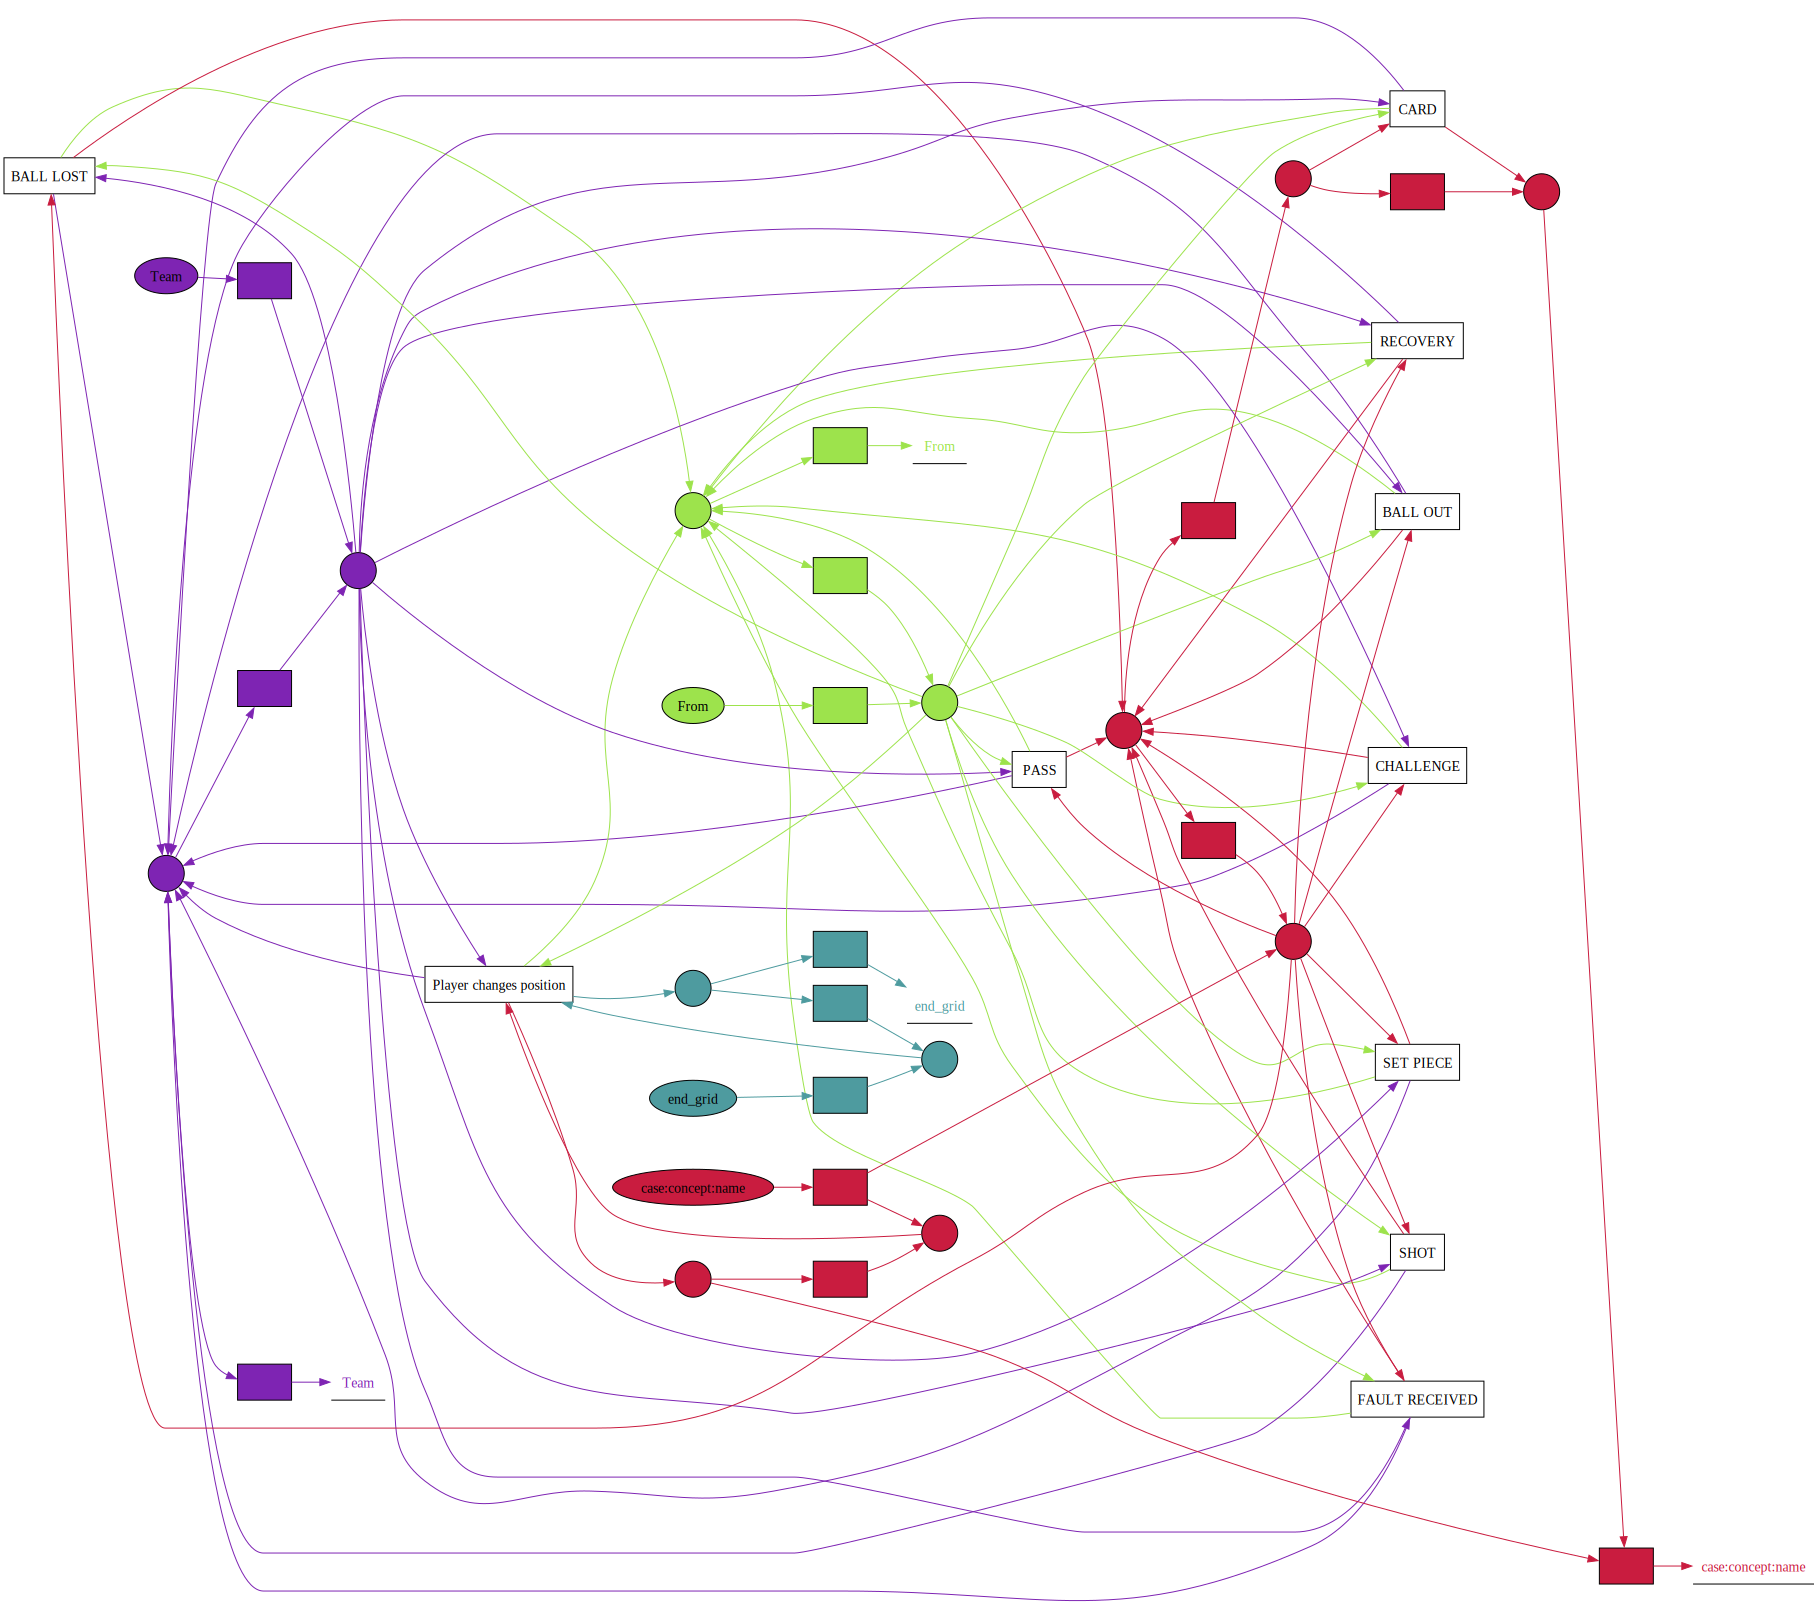

In [5]:
ocpn=pm4py.algo.discovery.ocel.ocpn.algorithm.apply(ocel)
pm4py.visualization.ocel.ocpn.visualizer.apply(ocpn)

In [10]:
obj_graph = pm4py.ocel_discover_objects_graph(ocel, graph_type='object_interaction')
pm4py.visualization.ocel.objects_graph.visualizer.apply(obj_graph, parameters={"format": "svg"})

AttributeError: module 'pm4py' has no attribute 'ocel_discover_objects_graph'

In [9]:
objects_summary = pm4py.ocel_objects_summary(ocel)

In [17]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
objects_summary

ocel:oid  \
0          A1   
1         A10   
2         A11   
3          A2   
4          A3   
5          A4   
6          A5   
7          A6   
8          A7   
9          A8   
10         A9   
11        AA1   
12       AA10   
13      AA100   
14      AA101   
15      AA102   
16      AA103   
17      AA104   
18      AA105   
19      AA106   
20      AA107   
21      AA108   
22      AA109   
23       AA11   
24      AA110   
25      AA111   
26      AA112   
27      AA113   
28      AA114   
29      AA115   
30      AA116   
31      AA117   
32      AA118   
33      AA119   
34       AA12   
35      AA120   
36      AA121   
37      AA122   
38      AA123   
39      AA124   
40      AA125   
41      AA126   
42      AA127   
43      AA128   
44      AA129   
45       AA13   
46      AA130   
47      AA131   
48      AA132   
49      AA133   
50      AA134   
51      AA135   
52      AA136   
53      AA137   
54      AA138   
55      AA139   
56       AA14   
57      AA140   
58      AA141   
59      AA142   
60      AA143   
61      AA144   
62      AA145   
63      AA146   
64      AA147   
65      AA148   
66      AA149   
67       AA15   
68      AA150   
69      AA151   
70      AA152   
71      AA153   
72      AA154   
73      AA155   
74      AA156   
75      AA157   
76      AA158   
77      AA159   
78       AA16   
79      AA160   
80      AA161   
81      AA162   
82      AA163   
83      AA164   
84      AA165   
85      AA166   
86      AA167   
87      AA168   
88      AA169   
89       AA17   
90      AA170   
91      AA171   
92      AA172   
93      AA173   
94      AA174   
95      AA175   
96       AA18   
97       AA19   
98        AA2   
99       AA20   
100      AA21   
101      AA22   
102      AA23   
103      AA24   
104      AA25   
105      AA26   
106      AA27   
107      AA28   
108      AA29   
109       AA3   
110      AA30   
111      AA31   
112      AA32   
113      AA33   
114      AA34   
115      AA35   
116      AA36   
117      AA37   
118      AA38   
119      AA39   
120       AA4   
121      AA40   
122      AA41   
123      AA42   
124      AA43   
125      AA44   
126      AA45   
127      AA46   
128      AA47   
129      AA48   
130      AA49   
131       AA5   
132      AA50   
133      AA51   
134      AA52   
135      AA53   
136      AA54   
137      AA55   
138      AA56   
139      AA57   
140      AA58   
141      AA59   
142       AA6   
143      AA60   
144      AA61   
145      AA62   
146      AA63   
147      AA64   
148      AA65   
149      AA66   
150      AA67   
151      AA68   
152      AA69   
153       AA7   
154      AA70   
155      AA71   
156      AA72   
157      AA73   
158      AA74   
159      AA75   
160      AA76   
161      AA77   
162      AA78   
163      AA79   
164       AA8   
165      AA80   
166      AA81   
167      AA82   
168      AA83   
169      AA84   
170      AA85   
171      AA86   
172      AA87   
173      AA88   
174      AA89   
175       AA9   
176      AA90   
177      AA91   
178      AA92   
179      AA93   
180      AA94   
181      AA95   
182      AA96   
183      AA97   
184      AA98   
185      AA99   
186      Away   
187        B1   
188       B10   
189       B11   
190        B2   
191        B3   
192        B4   
193        B5   
194        B6   
195        B7   
196        B8   
197        B9   
198        C1   
199       C10   
200       C11   
201        C2   
202        C3   
203        C4   
204        C5   
205        C6   
206        C7   
207        C8   
208        C9   
209        D1   
210       D10   
211       D11   
212        D2   
213        D3   
214        D4   
215        D5   
216        D6   
217        D7   
218        D8   
219        D9   
220        E1   
221       E10   
222       E11   
223        E2   
224        E3   
225        E4   
226        E5   
227        E6   
228        E7   
229        E8   
230        E9   
231        F1   
232       F10   
233       F11   
234       

In [ ]:
objects_summary['unique_activites'] = objects_summary['activities_lifecycle'].apply(lambda x: list(set(x)))
objects_summary_player=objects_summary[objects_summary['ocel:oid'].str.lower().str.startswith('player')]

In [31]:
mask_with = objects_summary_player['activities_lifecycle'].apply(lambda x: 'FAULT RECEIVED' in x)
print(objects_summary_player.loc[mask_with, 'ocel:oid'])

478     Player1
479    Player10
481    Player12
482    Player13
486    Player17
487    Player18
488    Player19
493    Player23
497    Player27
498    Player28
499     Player3
502     Player6
503     Player7
504     Player8
505     Player9
Name: ocel:oid, dtype: object


In [33]:
mask_without = objects_summary_player['activities_lifecycle'].apply(lambda x: 'FAULT RECEIVED' not in x)
print(objects_summary_player.loc[mask_without, 'ocel:oid'])

480    Player11
483    Player14
484    Player15
485    Player16
489     Player2
490    Player20
491    Player21
492    Player22
494    Player24
495    Player25
496    Player26
500     Player4
501     Player5
Name: ocel:oid, dtype: object


In [16]:
player_stats=pd.DataFrame()
player_stats['ocel:oid'] = objects_summary_player['ocel:oid']
player_stats['fault'] = objects_summary_player['activities_lifecycle'].apply(lambda x: x.count('FAULT RECEIVED'))
player_stats['ball_lost'] = objects_summary_player['activities_lifecycle'].apply(lambda x: x.count('BALL LOST'))
player_stats['card'] = objects_summary_player['activities_lifecycle'].apply(lambda x: x.count('CARD'))
player_stats['shot'] = objects_summary_player['activities_lifecycle'].apply(lambda x: x.count('SHOT'))
player_stats['recovery'] = objects_summary_player['activities_lifecycle'].apply(lambda x: x.count('RECOVERY'))
player_stats['set_piece'] = objects_summary_player['activities_lifecycle'].apply(lambda x: x.count('SET PIECE'))
player_stats['ball_out'] = objects_summary_player['activities_lifecycle'].apply(lambda x: x.count('BALL OUT'))
player_stats['away_team'] = objects_summary_player['interacting_objects'].apply(lambda x: 'Away' in x)
player_stats['home_team'] = objects_summary_player['interacting_objects'].apply(lambda x: 'Home' in x)
player_stats.sort_values(by='home_team', inplace=True)
player_stats

ocel:oid  fault  ball_lost  card  shot  recovery  set_piece  ball_out  \
491  Player21      0         15     0     1         8          6         1   
494  Player24      0          2     0     1         0          0         0   
493  Player23      1          4     0     1         4          1         1   
492  Player22      0         11     0     0        12          8         5   
497  Player27      1          2     0     1         4          0         1   
490  Player20      0          4     0     0        10          1         3   
498  Player28      2          2     0     1         1          0         1   
488  Player19      1         23     0     1        14          7         3   
495  Player25      0          9     0     0        20          3         3   
487  Player18      1         15     0     0         9          2         2   
485  Player16      0          9     0     0        21          2         5   
484  Player15      0         12     1     0        22          0         5   
486  Player17      1         17     0     0        16          2         2   
496  Player26      0          3     1     0         2          0         1   
499   Player3      1          8     0     0        16          3         2   
500   Player4      0         10     0     0        11          6         2   
501   Player5      0          8     1     2        10          0         1   
502   Player6      3          8     0     0        12         13         1   
503   Player7      1         14     0     2        11         10         2   
478   Player1      1          7     0     0         7          1         1   
489   Player2      0         15     0     0        18          4         3   
483  Player14      0          5     1     1         2          0         0   
482  Player13      1          0     0     0         0          0         0   
481  Player12      2          6     0     1         8          1         0   
480  Player11      0         13     0     0        19          4         1   
479  Player10      2         12     0     4         3          2         1   
504   Player8      3         17     0     4        13          0         3   
505   Player9      1          6     0     4         5          1         1   

     away_team  home_team  
491       True      False  
494       True      False  
493       True      False  
492       True      False  
497       True      False  
490       True      False  
498       True      False  
488       True      False  
495       True      False  
487       True      False  
485       True      False  
484       True      False  
486       True      False  
496       True      False  
499      False       True  
500      False       True  
501      False       True  
502      False       True  
503      False       True  
478      False       True  
489      False       True  
483      False       True  
482      False       True  
481      False       True  
480      False       True  
479      False       True  
504      False       True  
505      False       True

In [ ]:
#took super long not sure if it works
#pm4py.ocel.ocel_temporal_summary(ocel)

In [23]:
pm4py.statistics.ocel.act_utils.find_associations_from_ocel(ocel, {'EVENT_ACTIVIT':'SHOT'})

{'BALL LOST': [('2216', 'Away'),
  ('2216', 'Player17'),
  ('2216', 'AA1'),
  ('2421', 'Home'),
  ('2421', 'Player2'),
  ('2421', 'HA1'),
  ('2889', 'Away'),
  ('2889', 'Player16'),
  ('2889', 'AA2'),
  ('3643', 'Home'),
  ('3643', 'Player10'),
  ('3643', 'HA2'),
  ('7052', 'Away'),
  ('7052', 'Player17'),
  ('7052', 'AA3'),
  ('8748', 'Home'),
  ('8748', 'Player8'),
  ('8748', 'HA3'),
  ('27779', 'Home'),
  ('27779', 'Player10'),
  ('27779', 'HA5'),
  ('28053', 'Away'),
  ('28053', 'Player19'),
  ('28053', 'AA6'),
  ('28885', 'Home'),
  ('28885', 'Player1'),
  ('28885', 'HA6'),
  ('29441', 'Away'),
  ('29441', 'Player17'),
  ('29441', 'AA7'),
  ('31713', 'Away'),
  ('31713', 'Player19'),
  ('31713', 'AA8'),
  ('32486', 'Home'),
  ('32486', 'Player1'),
  ('32486', 'HA8'),
  ('32653', 'Away'),
  ('32653', 'Player19'),
  ('32653', 'AA9'),
  ('33196', 'Home'),
  ('33196', 'Player1'),
  ('33196', 'HA9'),
  ('34407', 'Away'),
  ('34407', 'Player18'),
  ('34407', 'AA10'),
  ('34502', 'Home')

In [27]:
ocel_logs_by_object_type

[Object-Centric Event Log (number of events: 904123, number of objects: 506, number of activities: 10, number of object types: 4, events-objects relationships: 2745516)
 Activities occurrences: Counter({'Player changes position': 902378, 'PASS': 799, 'RECOVERY': 278, 'BALL LOST': 257, 'CHALLENGE': 233, 'SET PIECE': 77, 'BALL OUT': 51, 'SHOT': 24, 'FAULT RECEIVED': 22, 'CARD': 4})
 Object types occurrences (number of objects): Counter({'case:concept:name': 355, 'end_grid': 121, 'From': 28, 'Team': 2})
 Unique activities per object type: Counter({'From': 10, 'Team': 10, 'case:concept:name': 10, 'To': 1, 'end_grid': 1})
 Please use <THIS>.get_extended_table() to get a dataframe representation of the events related to the objects.]

In [28]:
from pm4py.algo.transformation.ocel.split_ocel import algorithm as split_ocel
from pm4py.algo.discovery.dfg import algorithm as dfg_discovery
from pm4py.visualization.dfg import visualizer as dfg_visualizer

ocel_logs_by_object_type = split_ocel.apply(ocel)

attack_log = ocel_logs_by_object_type["case:concept:name"]
dfg = dfg_discovery.apply(attack_log)
gviz = dfg_visualizer.apply(dfg, variant="frequency")
dfg_visualizer.view(gviz)


TypeError: list indices must be integers or slices, not str

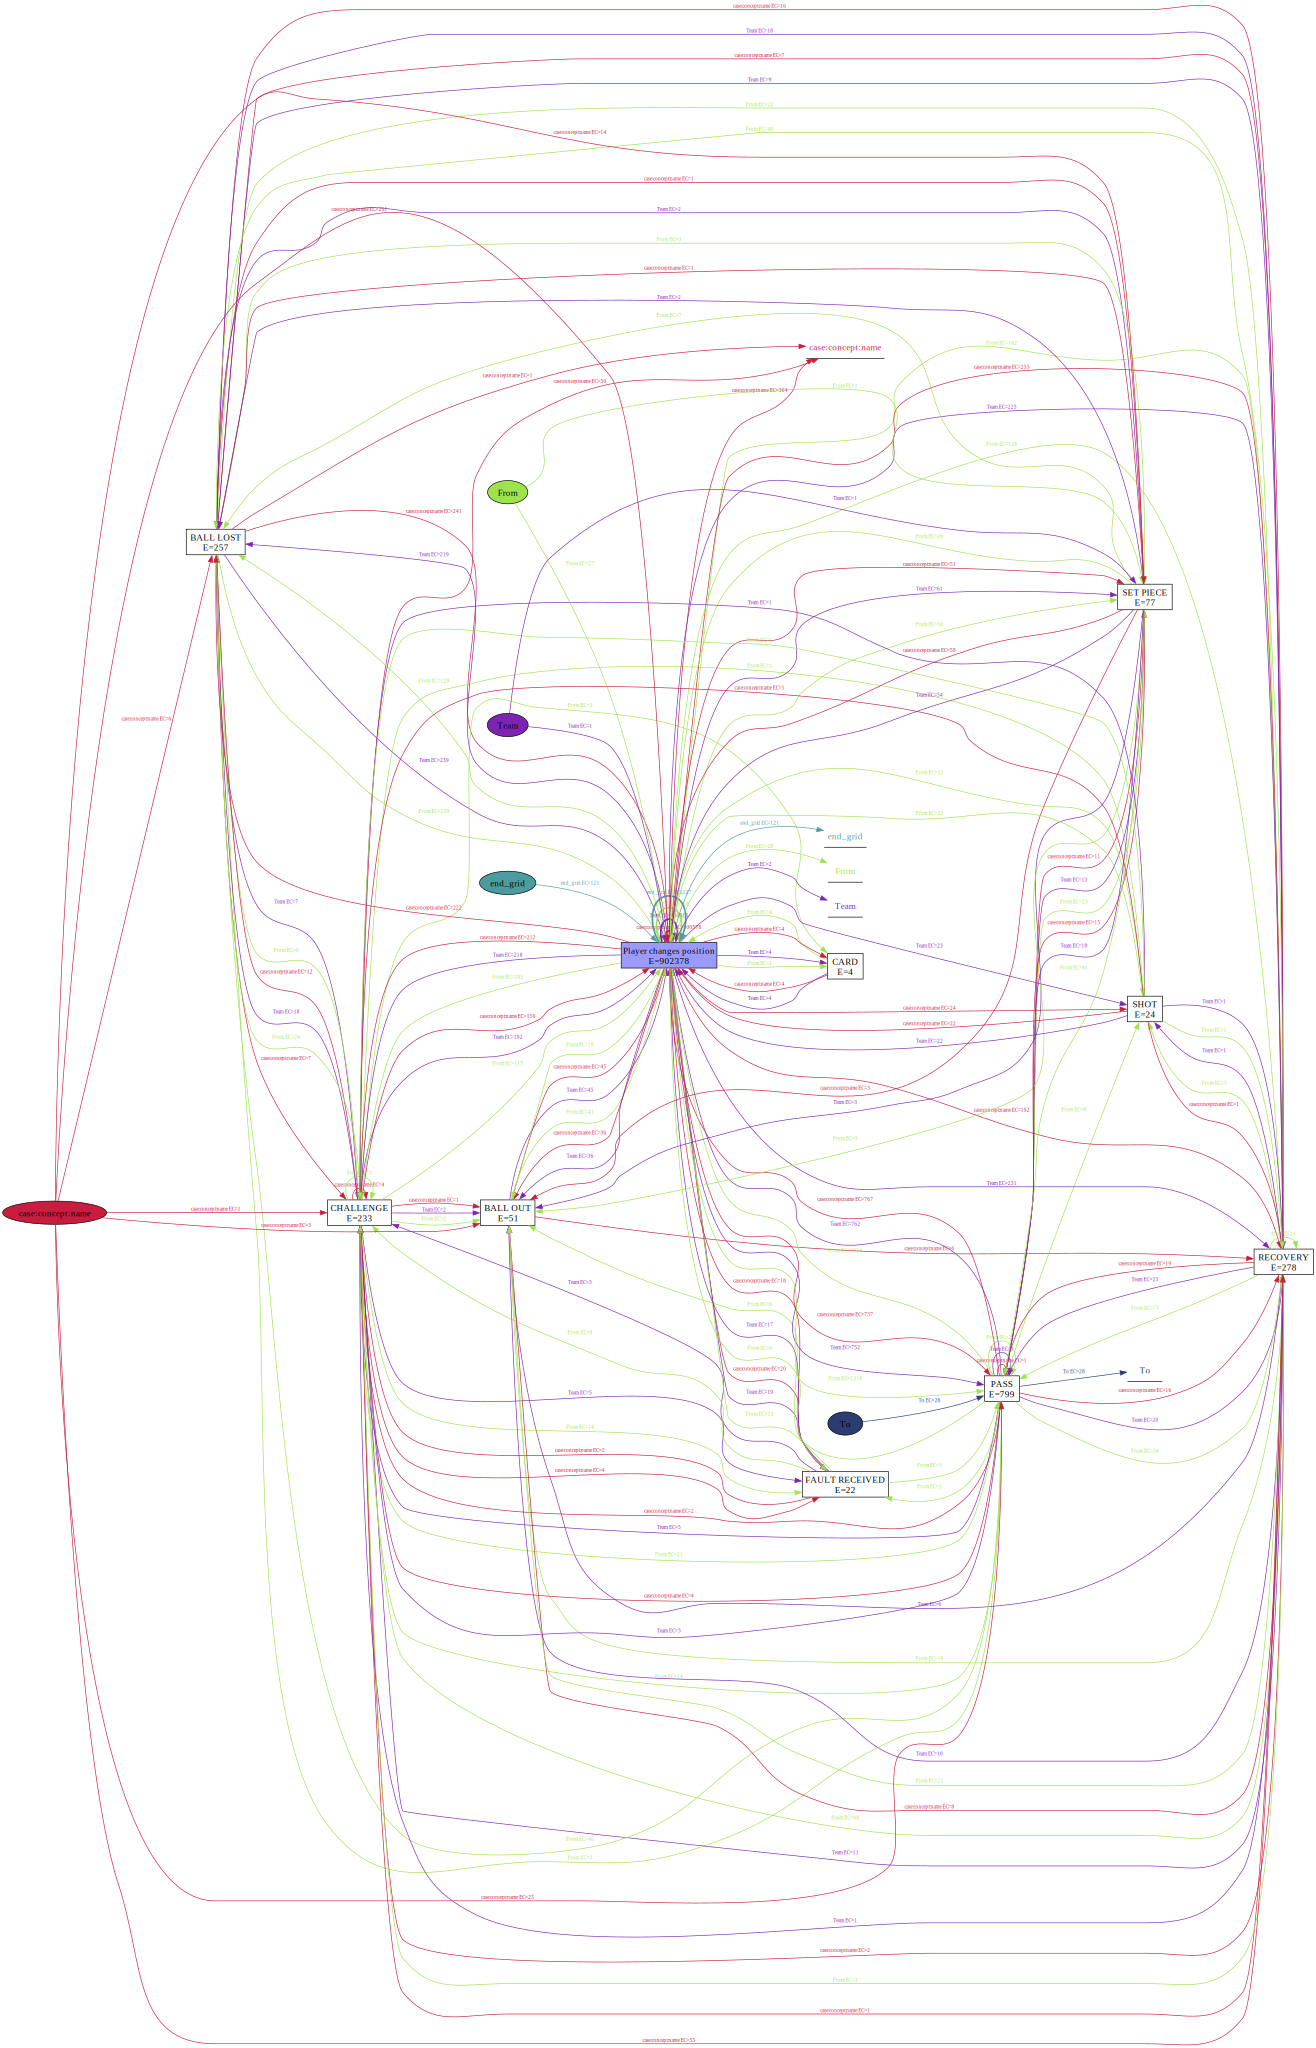

In [ ]:
dfg=pm4py.algo.discovery.ocel.ocdfg.variants.classic.apply(ocel,{'OBJECT_TYPE':'ocel:type:case:concept:name'})
pm4py.visualization.ocel.ocdfg.visualizer.apply(dfg)

In [32]:
from pm4py.algo.transformation.ocel.graphs import object_interaction_graph
obj_graph = object_interaction_graph.apply(ocel)#, {'graph_type':'object_interaction'})
obj_graph
#pm4py.visualization.ocel.objects_graph.visualizer.apply(obj_graph, parameters={"format": "svg"})

{('AA40', 'Player25'),
 ('HA47', 'Player23'),
 ('AA124', 'Player7'),
 ('D5', 'Player7'),
 ('G8', 'HA92'),
 ('D6', 'HA111'),
 ('AA162', 'Player9'),
 ('AA98', 'I4'),
 ('AA21', 'I5'),
 ('HA118', 'Player16'),
 ('H5', 'Player24'),
 ('AA101', 'I9'),
 ('AA98', 'Player14'),
 ('AA51', 'E6'),
 ('AA104', 'B7'),
 ('AA155', 'Player2'),
 ('H6', 'Player16'),
 ('G3', 'Player4'),
 ('HA32', 'Player3'),
 ('AA21', 'J1'),
 ('C3', 'Player23'),
 ('AA114', 'Player15'),
 ('HA107', 'Player12'),
 ('HA129', 'Player2'),
 ('Player17', 'Player26'),
 ('HA115', 'Player14'),
 ('Player17', 'Player19'),
 ('HA54', 'Player15'),
 ('C7', 'HA132'),
 ('HA152', 'Player7'),
 ('AA99', 'H1'),
 ('AA111', 'Player27'),
 ('HA49', 'Player25'),
 ('C8', 'Home'),
 ('HA81', 'Player22'),
 ('H5', 'HA32'),
 ('G10', 'Player12'),
 ('AA63', 'G3'),
 ('C5', 'Player6'),
 ('AA130', 'Player16'),
 ('AA19', 'I1'),
 ('D6', 'HA119'),
 ('I10', 'Player22'),
 ('AA44', 'Away'),
 ('E4', 'HA115'),
 ('HA111', 'Player25'),
 ('AA162', 'G1'),
 ('HA67', 'Player8'),

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(obj_graph)  # or use kamada_kawai_layout, shell_layout, etc.
nx.draw(obj_graph, pos, with_labels=True, node_size=5, font_size=10, arrows=True)
edge_labels = nx.get_edge_attributes(obj_graph, 'weight')  # or another attribute if used
nx.draw_networkx_edge_labels(obj_graph, pos, edge_labels=edge_labels)
plt.title("Object Interaction Graph")
plt.show()


In [ ]:
pm4py.algo.transformation.ocel.features.objects.object_degree_centrality.apply(ocel)